### MODELAGEM PREDITIVA PARA SÉRIES TEMPORAIS

#### USUÁRIOS ATIVOS EM WEBSITE

In [12]:
!pip install -q -U statsmodels


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [9]:
import pandas as pd
import numpy as np

In [141]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib as m

In [208]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
# Imports para métricas e performance do modelo
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

from datetime import datetime


In [14]:
  # Formatação para os gráficos e tabelas
plt.style.use('ggplot')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# Formatando os labels dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

In [15]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Bruno Ramos Lemos" 

Author: Bruno Ramos Lemos



In [40]:
schema = {
  'mes' : 'object',
  'usuarios_ativos': 'int64',
}

In [41]:
dados = pd.read_csv("./dataset.csv", header= None, names = schema)

In [42]:
dados.describe()

usuarios_ativos
count       144.000000
mean        280.416667
std         119.825543
min         104.000000
25%         180.000000
50%         265.500000
75%         360.500000
max         622.000000

In [45]:
dados.tail()

mes  usuarios_ativos
139  2024-08              606
140  2024-09              508
141  2024-10              461
142  2024-11              390
143  2024-12              432

In [47]:
dados.head(10)

mes  usuarios_ativos
0  2013-01              110
1  2013-02              121
2  2013-03              135
3  2013-04              127
4  2013-05              128
5  2013-06              136
6  2013-07              149
7  2013-08              150
8  2013-09              138
9  2013-10              119

In [48]:
dados.shape

(144, 2)

In [49]:
dados.dtypes

mes                object
usuarios_ativos     int64
dtype: object

In [50]:
type(dados)

pandas.core.frame.DataFrame

In [51]:
dados.max()

mes                2024-12
usuarios_ativos        622
dtype: object

In [52]:
print('Inicio do Periodo: {} \nFim do Periodo: {}'.format(dados['mes'].min(), dados['mes'].max()))

Inicio do Periodo: 2013-01 
Fim do Periodo: 2024-12


In [53]:
dados['mes'] = pd.to_datetime(dados['mes'], format='%Y-%m')

In [54]:
dados.head()

mes  usuarios_ativos
0 2013-01-01              110
1 2013-02-01              121
2 2013-03-01              135
3 2013-04-01              127
4 2013-05-01              128

In [55]:
dados_serie = dados.set_index('mes')

In [56]:
type(dados_serie)

pandas.core.frame.DataFrame

In [57]:
dados_serie

usuarios_ativos
mes                        
2013-01-01              110
2013-02-01              121
2013-03-01              135
2013-04-01              127
2013-05-01              128
...                     ...
2024-08-01              606
2024-09-01              508
2024-10-01              461
2024-11-01              390
2024-12-01              432

[144 rows x 1 columns]

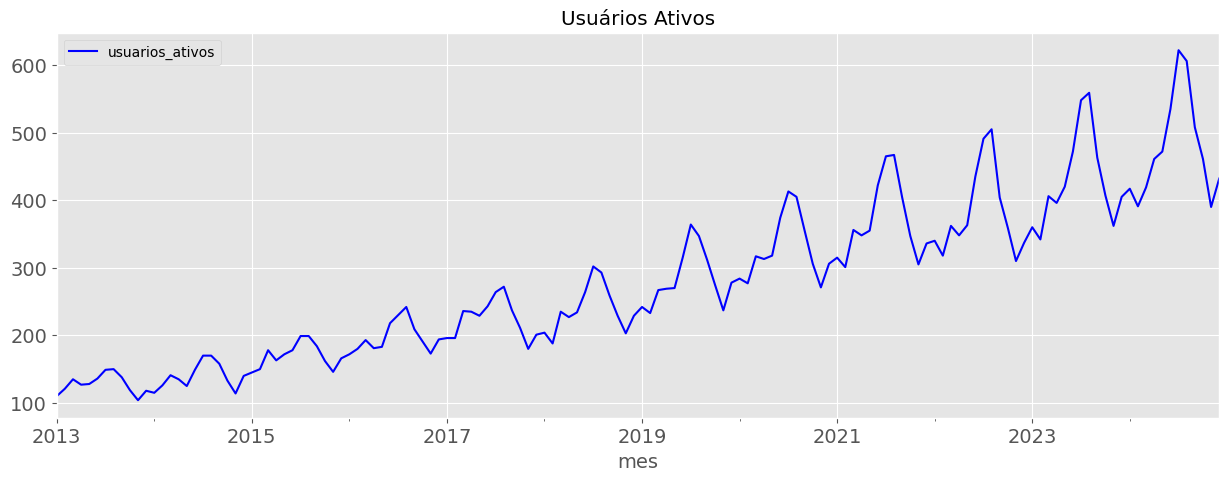

In [59]:
dados_serie.plot(figsize=(15, 5), title='Usuários Ativos', color='blue', fontsize=14)
plt.show()

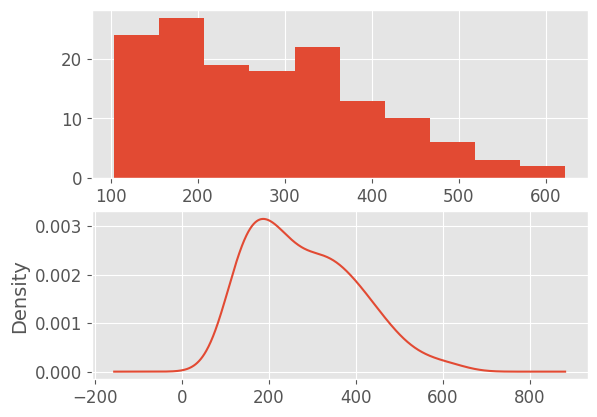

In [60]:
# Gráfico de Densidade

# Plot
plt.figure(1)

# Subplot 1
plt.subplot(211)
dados_serie.usuarios_ativos.hist()

# Subplot 2
plt.subplot(212)
dados_serie.usuarios_ativos.plot(kind = 'kde')
plt.show()

Text(0, 0.5, '\nUsuários Ativos')

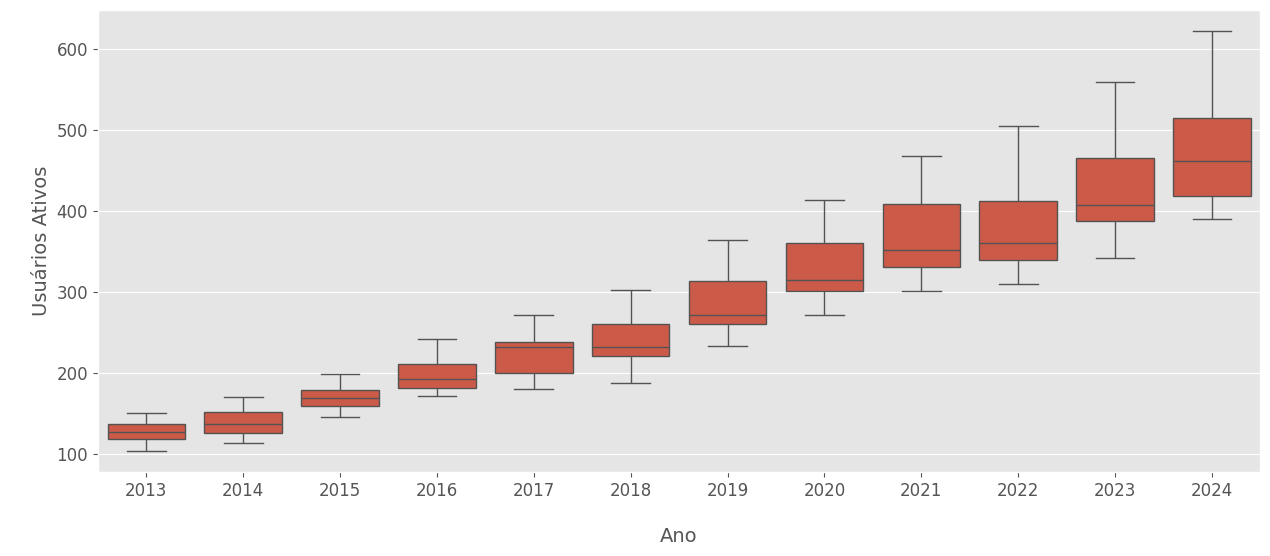

In [61]:
# Define a área de plotagem para os subplots (os boxplots)
fig, ax = plt.subplots(figsize = (15,6))

# Define as variáveis
indice_ano = dados_serie.usuarios_ativos.index.year
valor = dados_serie.usuarios_ativos

# Cria um box plot para cada ano usando o Seaborn
# Observe que estamos extraindo o ano (year) do índice da série
sns.boxplot(x = indice_ano, y = valor, ax = ax, data = dados_serie)

plt.xlabel("\nAno")
plt.ylabel("\nUsuários Ativos")

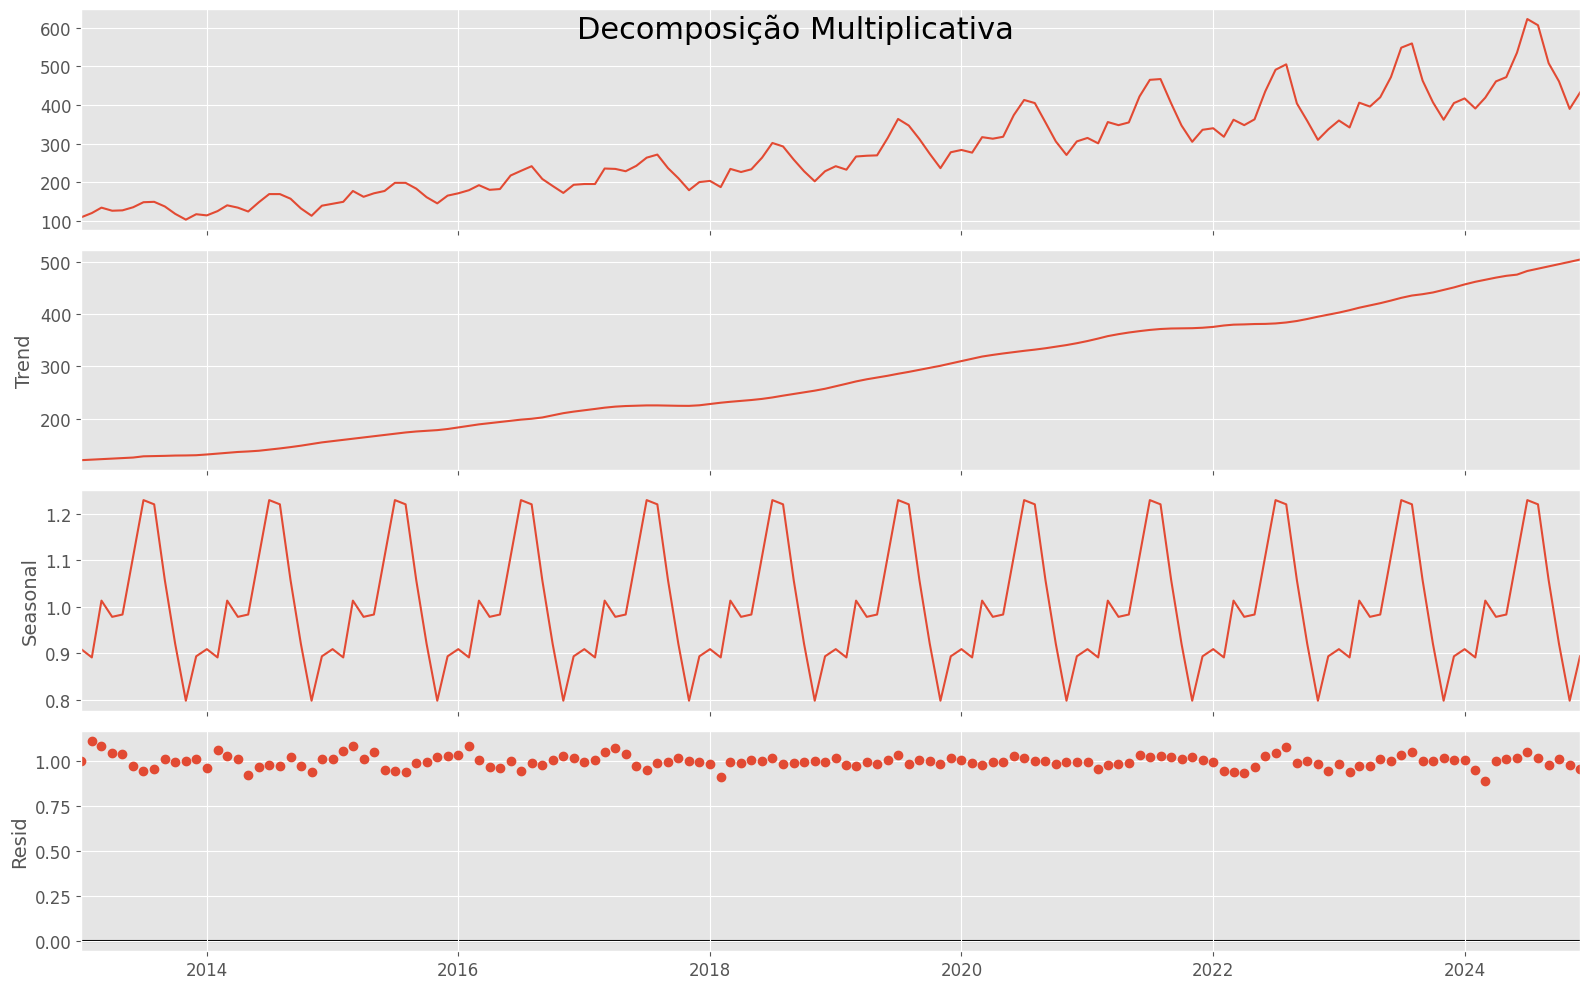

In [62]:
# Decomposição Multiplicativa
decomposicao_multiplicativa = sm.tsa.seasonal_decompose(dados_serie, 
                                                        model = 'multiplicative', 
                                                        extrapolate_trend = 'freq')
# Plot
plt.rcParams.update({'figure.figsize': (16,10)})
decomposicao_multiplicativa.plot().suptitle('Decomposição Multiplicativa', fontsize = 22)
plt.show()

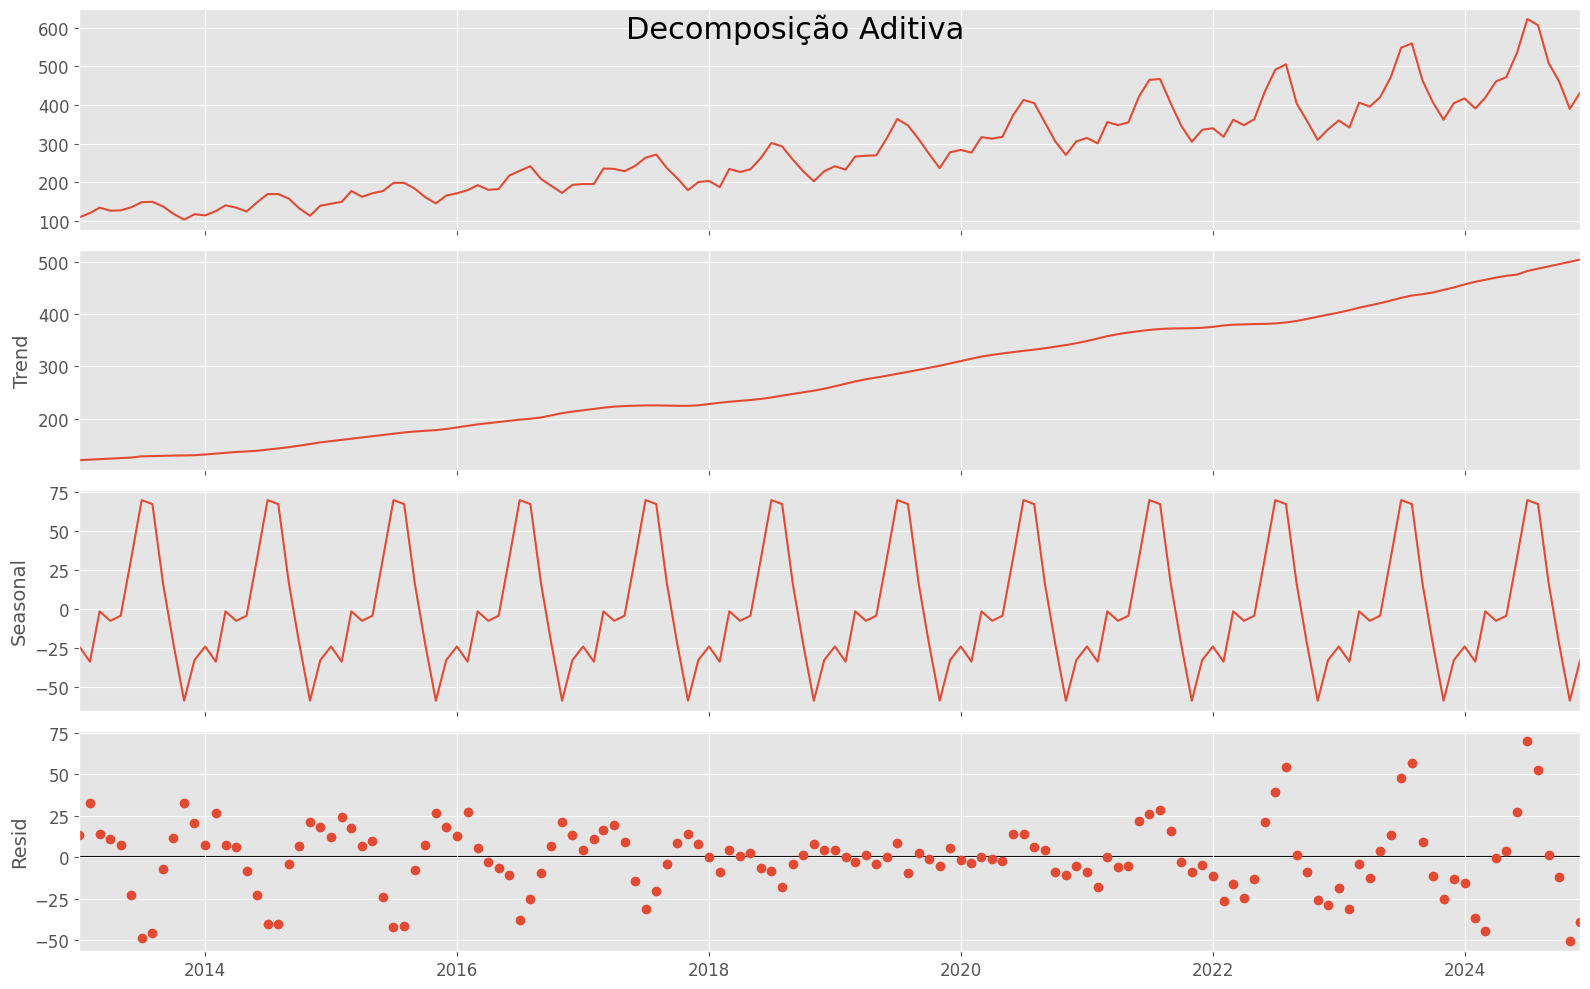

In [63]:
# Decomposição Aditiva
decomposicao_aditiva = sm.tsa.seasonal_decompose(dados_serie, 
                                                 model = 'aditive', 
                                                 extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (16,10)})
decomposicao_aditiva.plot().suptitle('Decomposição Aditiva', fontsize = 22)
plt.show()

In [64]:
# Concatena o resultado da decomposição da série
dados_serie_reconstruida = pd.concat([decomposicao_multiplicativa.seasonal, 
                                      decomposicao_multiplicativa.trend, 
                                      decomposicao_multiplicativa.resid, 
                                      decomposicao_multiplicativa.observed], axis = 1)
# Define o nome das colunas
dados_serie_reconstruida.columns = ['Sazonalidade', 'Tendência', 'Resíduos', 'Valores_Observados']

In [65]:
dados_serie_reconstruida.head(10)

Sazonalidade   Tendência  Resíduos  Valores_Observados
mes                                                               
2013-01-01      0.908801  120.743930  1.002440               110.0
2013-02-01      0.890967  121.750194  1.115460               121.0
2013-03-01      1.013081  122.756459  1.085538               135.0
2013-04-01      0.978227  123.762723  1.048997               127.0
2013-05-01      0.983212  124.768988  1.043413               128.0
2013-06-01      1.108024  125.775253  0.975876               136.0
2013-07-01      1.229174  128.125000  0.946104               149.0
2013-08-01      1.220071  128.541667  0.956450               150.0
2013-09-01      1.056932  129.000000  1.012144               138.0
2013-10-01      0.920181  129.583333  0.997987               119.0

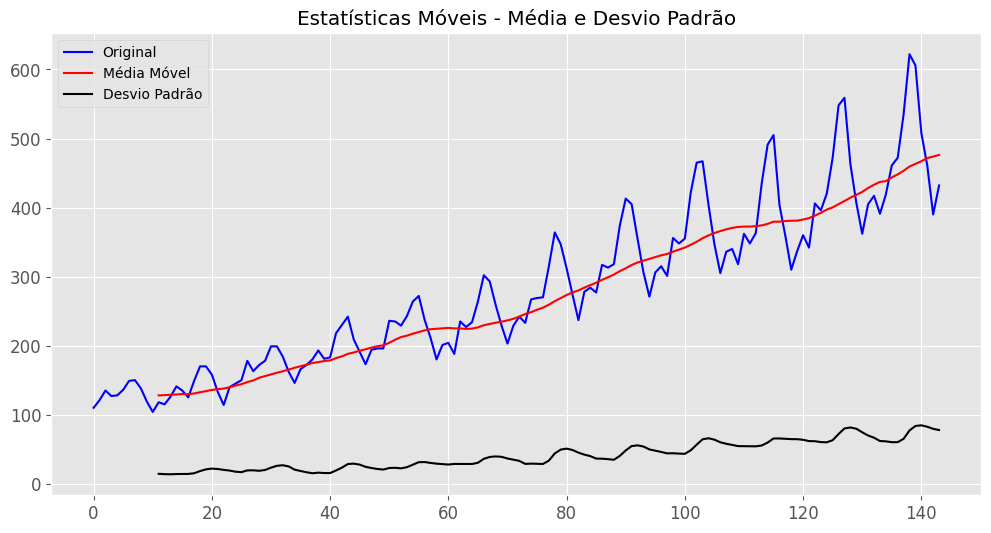

In [67]:
# Determinando estatísticas móveis
rolmean = dados['usuarios_ativos'].rolling(window = 12).mean()
rolstd = dados['usuarios_ativos'].rolling(window = 12).std()

# Prepara os dados para o plot
x = dados['mes'].values
y = dados['usuarios_ativos'].values

# Plot das estatísticas móveis
plt.figure(figsize = (12, 6))
orig = plt.plot(y, color = 'blue', label = 'Original')
mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
plt.legend(loc='best')
plt.title('Estatísticas Móveis - Média e Desvio Padrão')
plt.show()

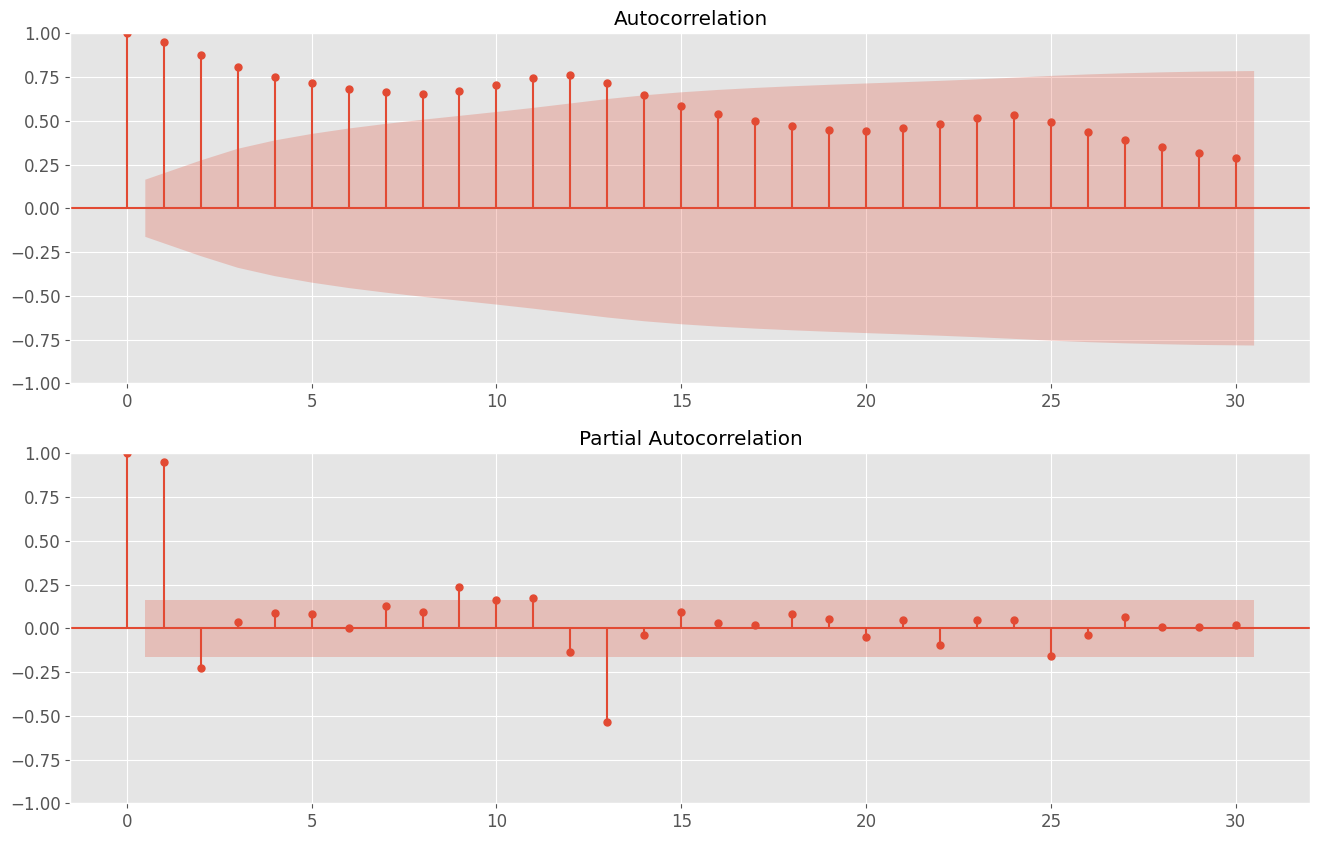

In [68]:
  # Plots
plt.rcParams.update({'figure.figsize': (16,10)})

# Plot do gráfico ACF
plt.subplot(211)
plot_acf(dados_serie.usuarios_ativos, ax = plt.gca(), lags = 30)

# Plot do gráfico PACF
plt.subplot(212)
plot_pacf(dados_serie.usuarios_ativos, ax = plt.gca(), lags = 30, method = 'ywm')
plt.show()

In [69]:
# Teste Dickey-Fuller

# Print
print('\nResultado do Teste Dickey-Fuller:\n')

# Teste
dfteste = adfuller(dados_serie.usuarios_ativos, autolag = 'AIC')

# Formatando a saída
dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                           'Valor-p',
                                           'Número de Lags Consideradas',
                                           'Número de Observações Usadas'])

# Loop por cada item da saída do teste
for key,value in dfteste[4].items():
    dfsaida['Valor Crítico (%s)'%key] = value

# Print
print (dfsaida)


Resultado do Teste Dickey-Fuller:

Estatística do Teste              0.809204
Valor-p                           0.991783
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64


In [70]:
# Função para testar a estacionaridade
def dsa_testa_estacionaridade(serie, window = 12, title = 'Estatísticas Móveis e Teste Dickey-Fuller'):
    """
    Função para testar a estacionaridade de uma série temporal.
    
    Parâmetros:
    - serie: pandas.Series. Série temporal a ser testada.
    - window: int. Janela para cálculo das estatísticas móveis.
    - title: str. Título para os gráficos.
    """
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = window).mean()
    rolstd = serie.rolling(window = window).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (14, 6))
    plt.plot(serie, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    plt.plot(rolstd, color = 'black', label = 'Desvio Padrão Móvel')
    plt.legend(loc = 'best')
    plt.title(title)
    plt.show(block = False)
    
    # Teste Dickey-Fuller
    print('\nResultado do Teste Dickey-Fuller:')
    dfteste = adfuller(serie, autolag = 'AIC')
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste', 
                                               'Valor-p', 
                                               'Número de Lags Consideradas', 
                                               'Número de Observações Usadas'])
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)' % key] = value
        
    print(dfsaida)
    
    # Conclusão baseada no valor-p
    if dfsaida['Valor-p'] > 0.05:
        print('\nConclusão:\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente não é estacionária.')
    else:
        print('\nConclusão:\nO valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente é estacionária.')

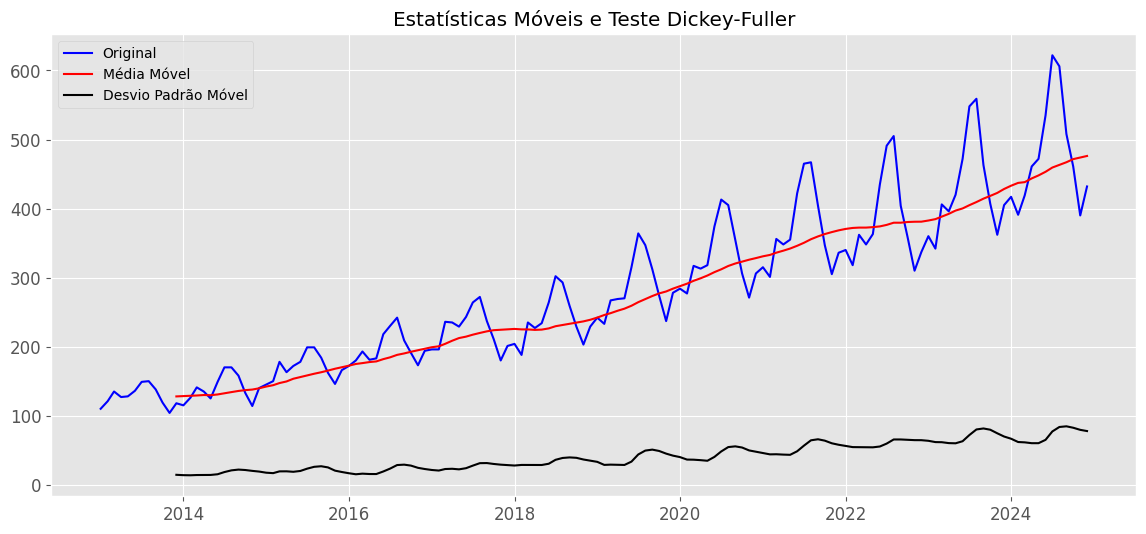


Resultado do Teste Dickey-Fuller:
Estatística do Teste              0.809204
Valor-p                           0.991783
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [71]:
dsa_testa_estacionaridade(dados_serie)

In [72]:
# Vamos aplicar uma transformação de log usando np.log() e gravamos o resultado em uma nova coluna do nosso dataset
dados['usuarios_ativos_log'] = np.log(dados['usuarios_ativos'])
dados.head()

mes  usuarios_ativos  usuarios_ativos_log
0 2013-01-01              110             4.700480
1 2013-02-01              121             4.795791
2 2013-03-01              135             4.905275
3 2013-04-01              127             4.844187
4 2013-05-01              128             4.852030

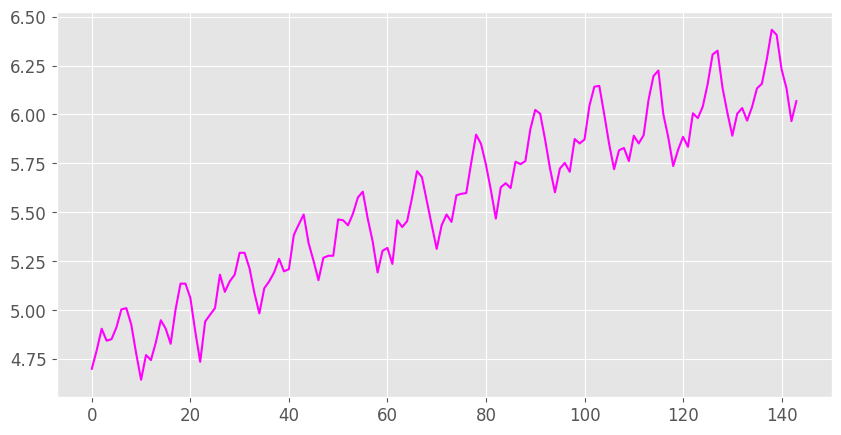

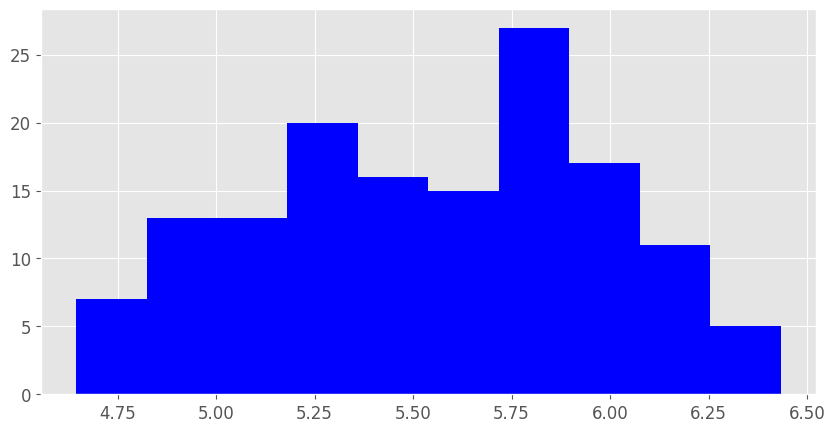

In [73]:
# Plot da série transformada
plt.figure(figsize = (10, 5))
plt.plot(dados['usuarios_ativos_log'], color = "magenta")
plt.show()

# Histograma da série transformada
plt.figure(figsize = (10, 5))
plt.hist(dados['usuarios_ativos_log'], color = "blue")
plt.show()

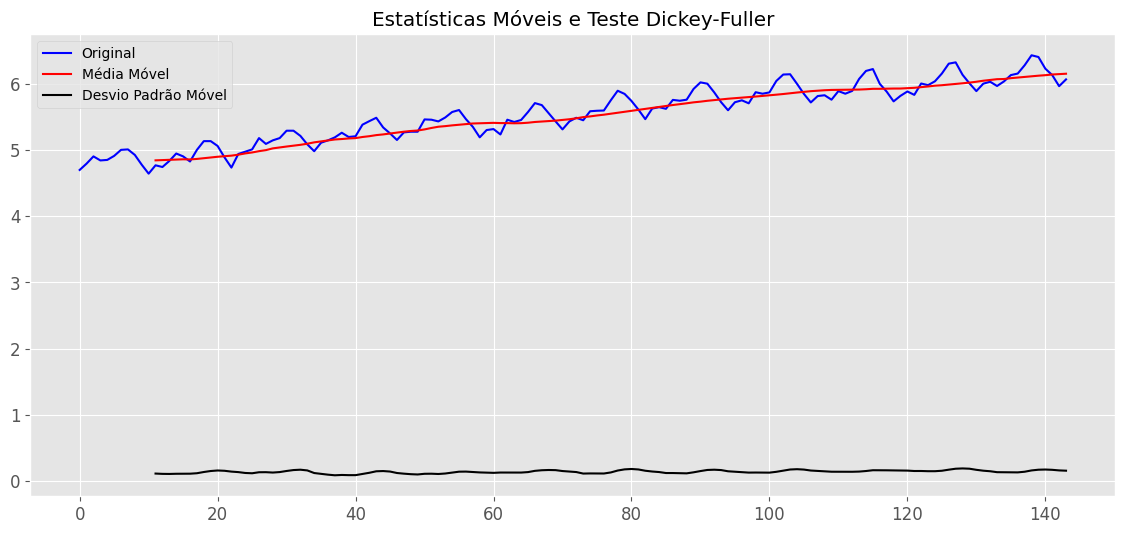


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -1.682091
Valor-p                           0.440363
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [75]:
dsa_testa_estacionaridade(dados['usuarios_ativos_log'])

In [76]:
# Transformação de Raiz Quadrada com np.sqrt()
dados_sqrt = np.sqrt(dados['usuarios_ativos'])

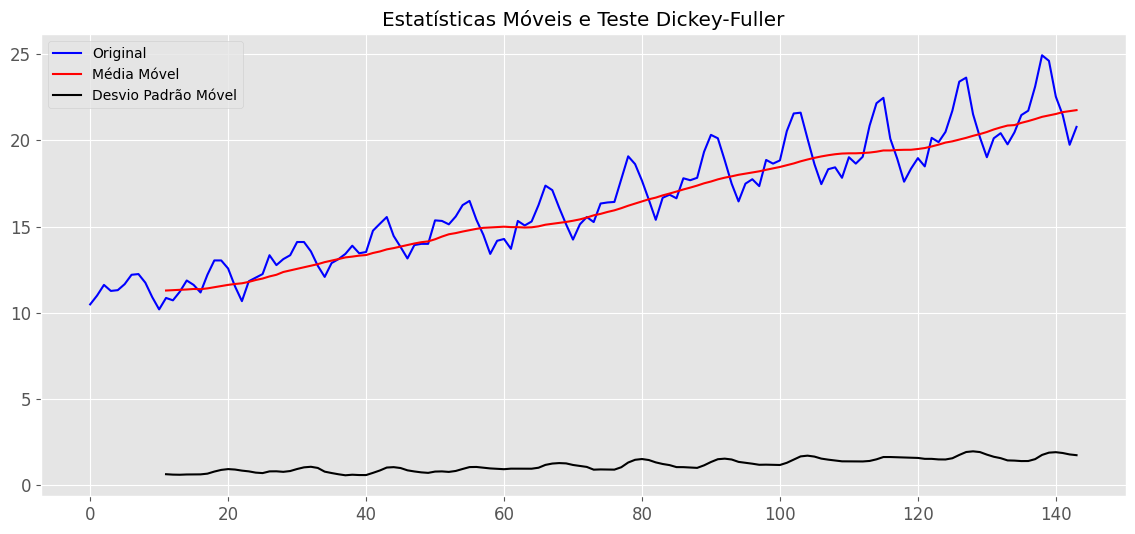


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -0.335165
Valor-p                           0.920374
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [77]:
dsa_testa_estacionaridade(dados_sqrt)

In [78]:
dados['usuarios_ativos_box'] = boxcox(dados['usuarios_ativos'], lmbda = 0.0)

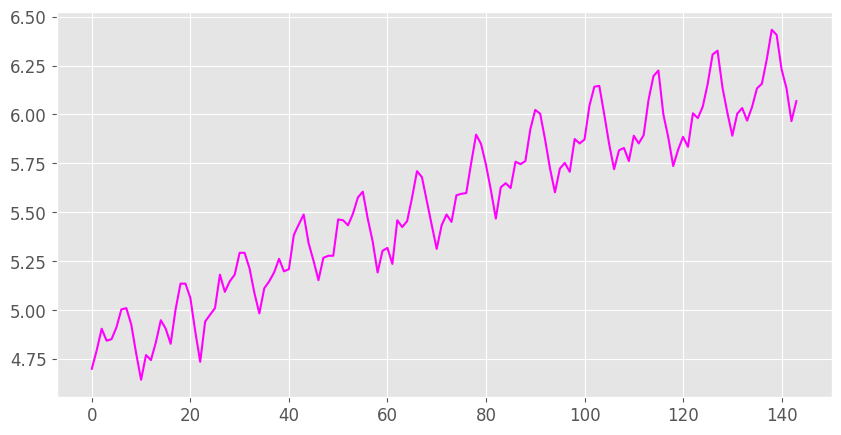

In [79]:
# Plot da série transformada
plt.figure(figsize = (10, 5))
plt.plot(dados['usuarios_ativos_box'], color = "magenta")
plt.show()

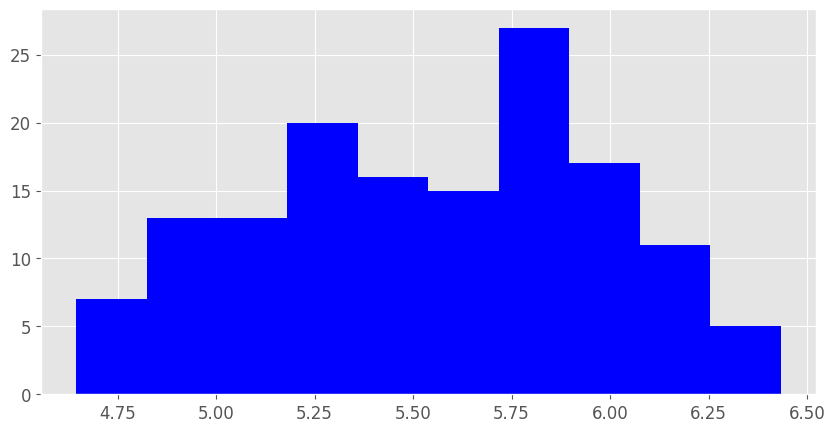

In [80]:
# Histograma
plt.figure(figsize = (10, 5))
plt.hist(dados['usuarios_ativos_box'], color = "blue")
plt.show()

In [81]:
# Aplicando Transformação Box-Cox
dados['usuarios_ativos_box_2'], lam_value = boxcox(dados['usuarios_ativos'])
print('Valor Ideal de Lambda: %f' % lam_value)
dados.head()

Valor Ideal de Lambda: 0.141909


mes  usuarios_ativos  usuarios_ativos_log  usuarios_ativos_box  usuarios_ativos_box_2
0 2013-01-01              110             4.700480             4.700480               6.683589
1 2013-02-01              121             4.795791             4.795791               6.870559
2 2013-03-01              135             4.905275             4.905275               7.088477
3 2013-04-01              127             4.844187             4.844187               6.966470
4 2013-05-01              128             4.852030             4.852030               6.982076

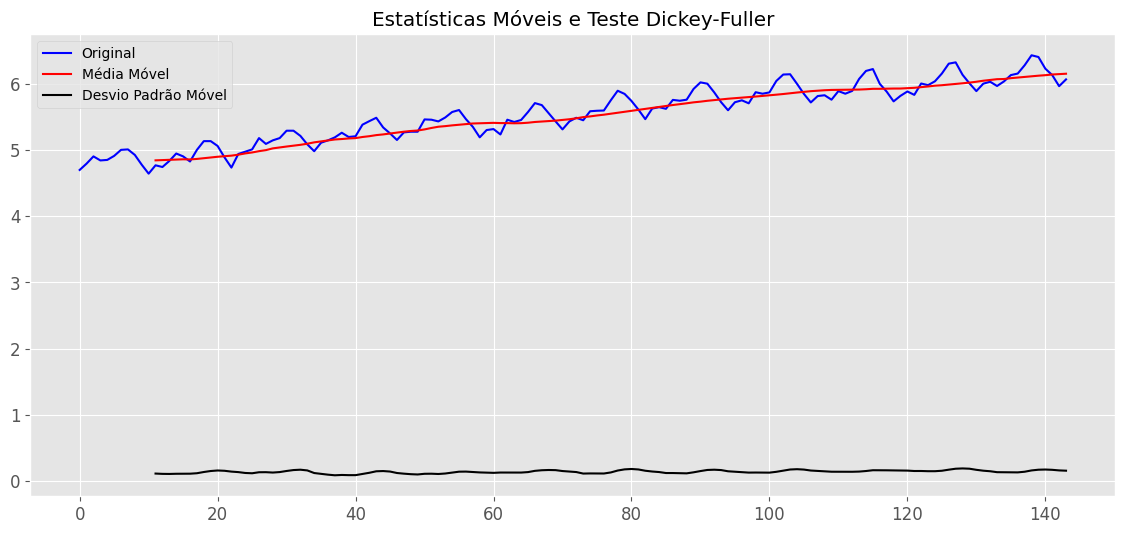


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -1.682091
Valor-p                           0.440363
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [82]:
dsa_testa_estacionaridade(dados['usuarios_ativos_box'])

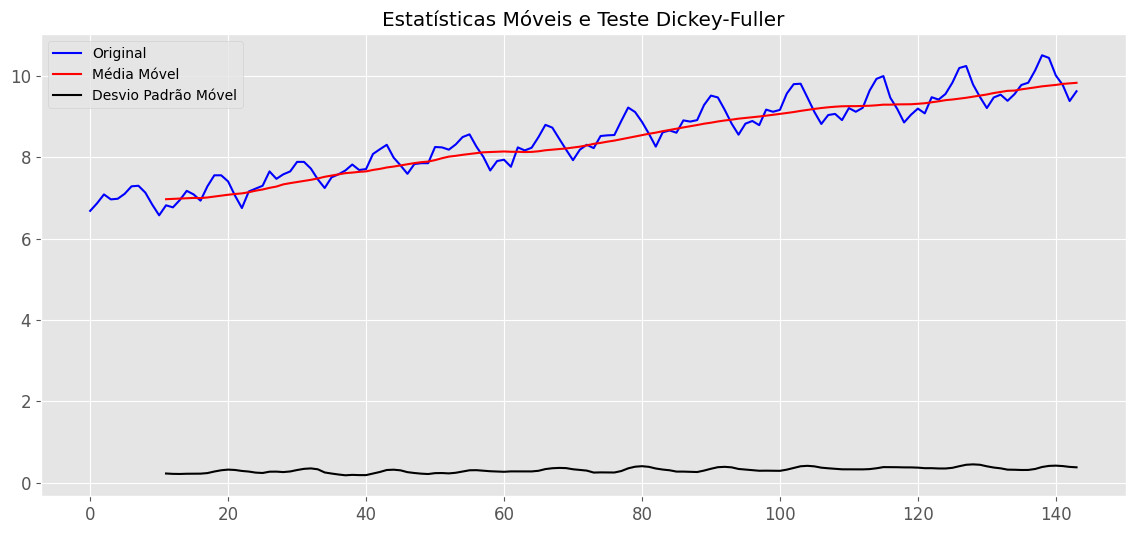


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -1.313294
Valor-p                           0.623069
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [83]:
dsa_testa_estacionaridade(dados['usuarios_ativos_box_2'])

In [84]:
# Vamos criar uma cópia da série original pois isso será importante mais tarde
df_serie = dados.copy()

In [88]:
dados = pd.read_csv("./dataset.csv", header= None, names = schema)

In [89]:
dados.set_index('mes', inplace=True)

In [90]:
# Agora definimos uma janela de 12 meses da série temporal para calcular a média móvel
# Vamos gravar o resultado em outra coluna no próprio dataset
dados['usuarios_ativos_media_movel_simples'] = dados.rolling(window = 12).mean()

In [91]:
dados.head()

usuarios_ativos  usuarios_ativos_media_movel_simples
mes                                                          
2013-01              110                                  NaN
2013-02              121                                  NaN
2013-03              135                                  NaN
2013-04              127                                  NaN
2013-05              128                                  NaN

In [95]:
dados.head(20)

usuarios_ativos  usuarios_ativos_media_movel_simples
mes                                                          
2013-01              110                                  NaN
2013-02              121                                  NaN
2013-03              135                                  NaN
2013-04              127                                  NaN
2013-05              128                                  NaN
2013-06              136                                  NaN
2013-07              149                                  NaN
2013-08              150                                  NaN
2013-09              138                                  NaN
2013-10              119                                  NaN
2013-11              104                                  NaN
2013-12              118                           127.916667
2014-01              115                           128.333333
2014-02              126                           128.750000
2014-03              141                           129.250000
2014-04              135                           129.916667
2014-05              125                           129.666667
2014-06              149                           130.750000
2014-07              170                           132.500000
2014-08              170                           134.166667

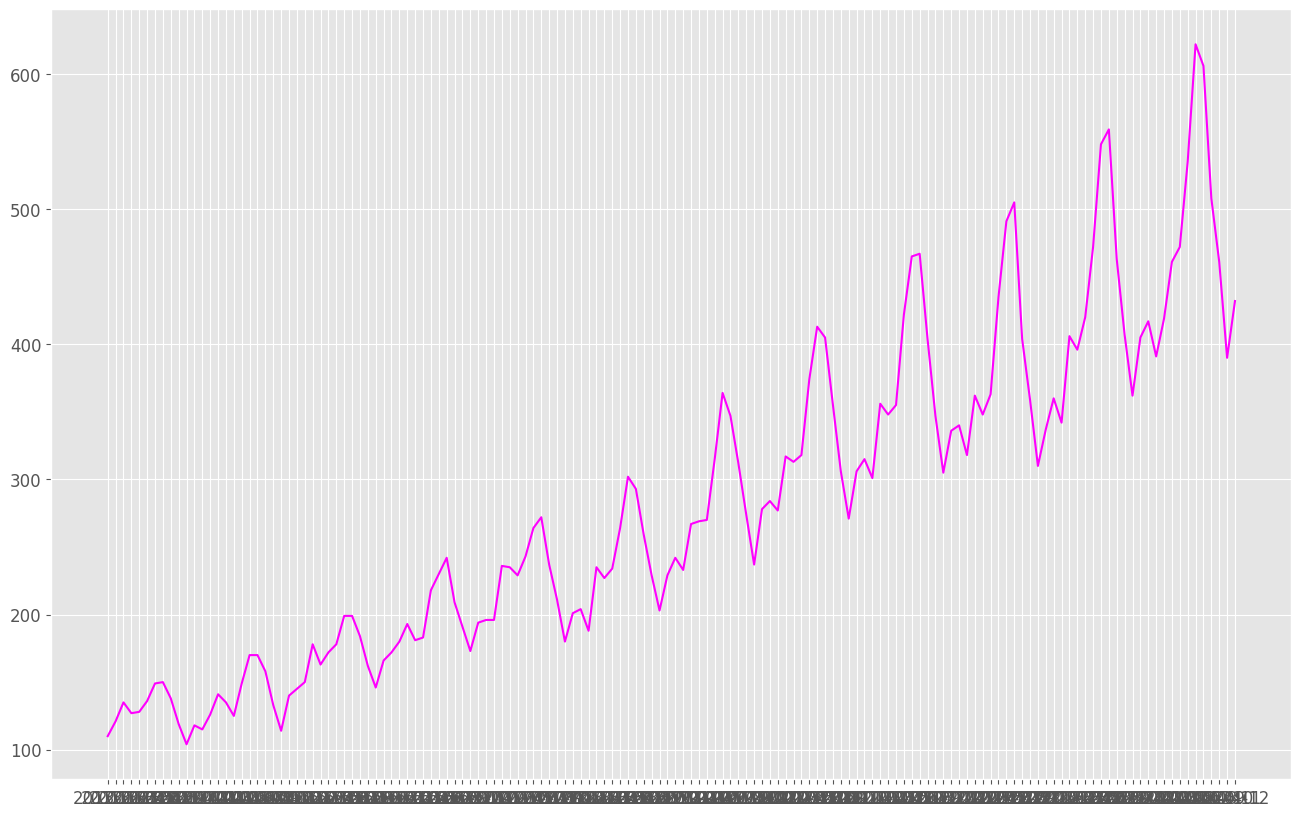

In [96]:
# Plot da série original
plt.plot(dados['usuarios_ativos'], color = 'magenta')
plt.show();

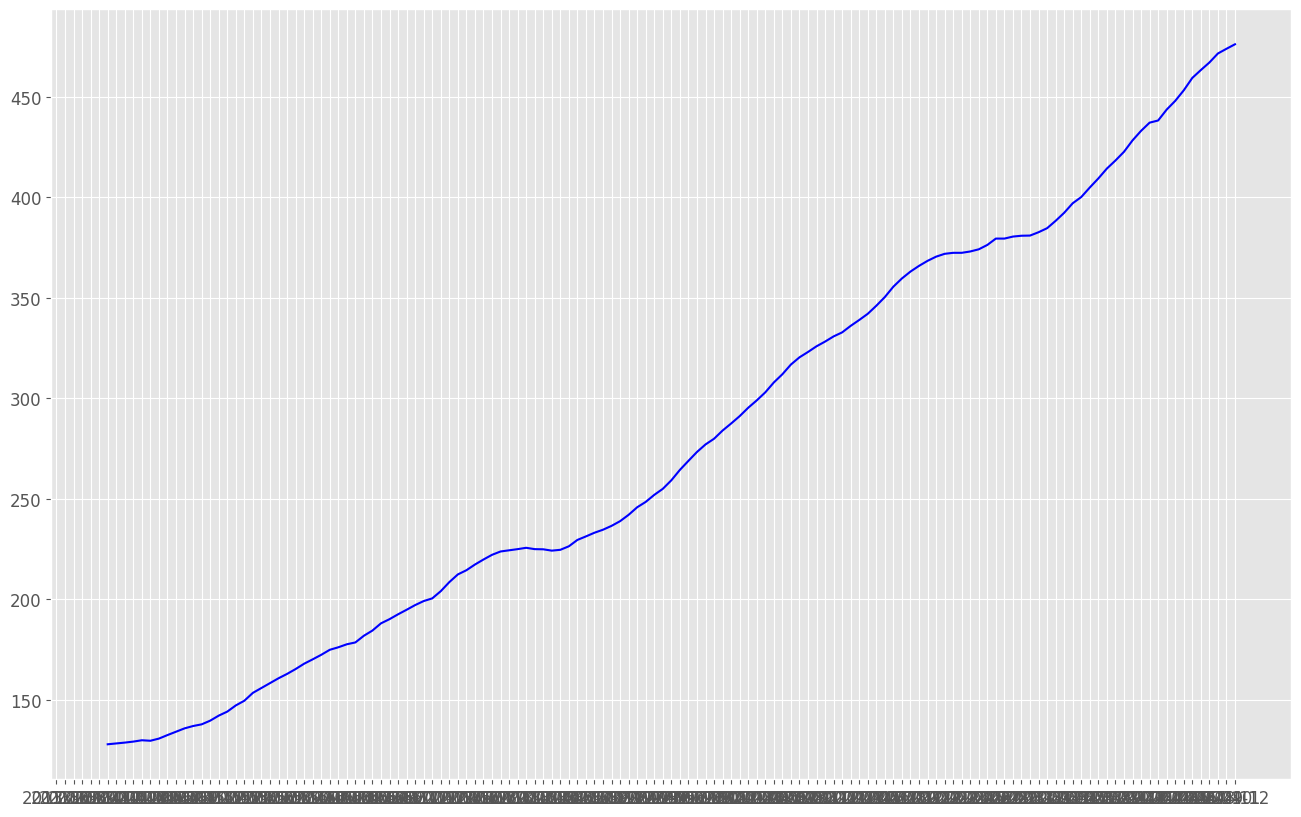

In [97]:
# Plot da série suavizada
plt.plot(dados['usuarios_ativos_media_movel_simples'], color = 'blue')
plt.show();

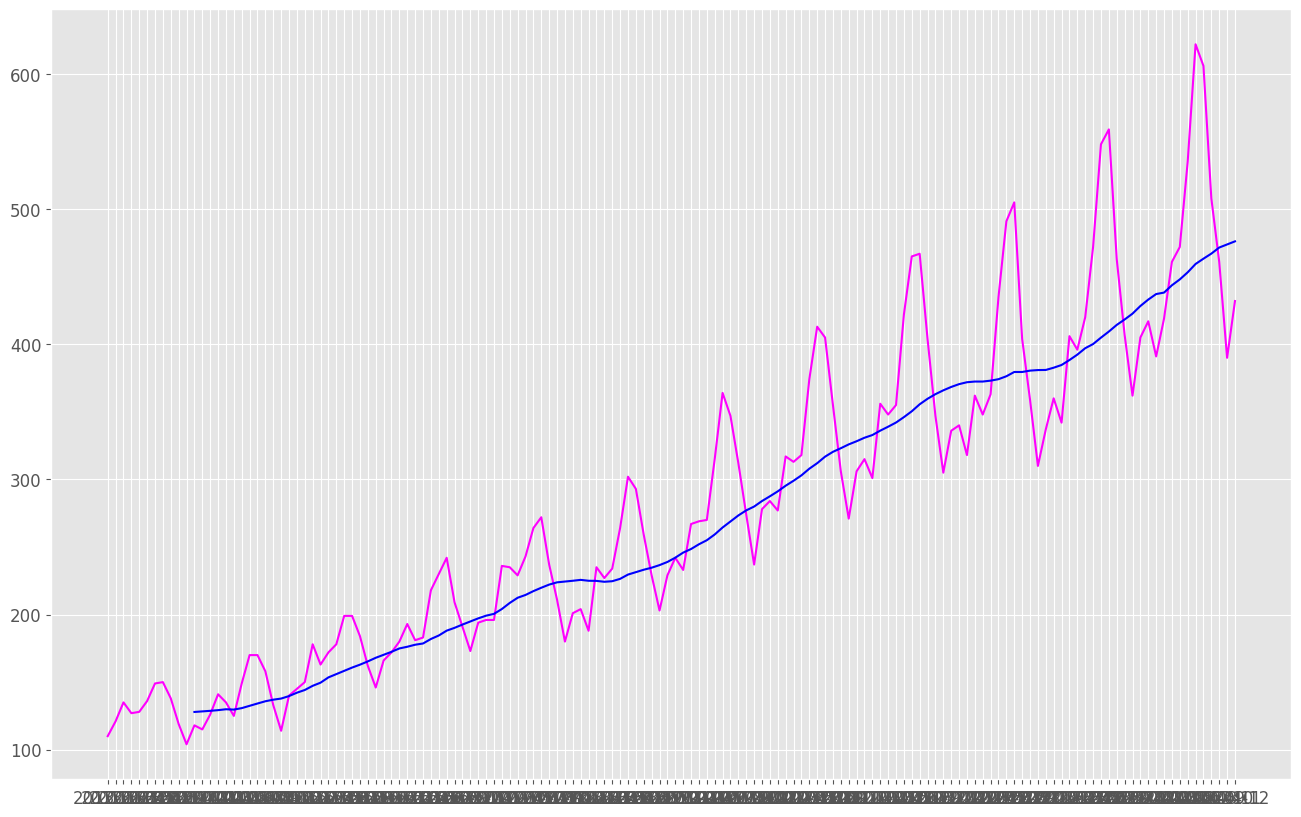

In [98]:
# Agora as duas juntas
plt.plot(dados['usuarios_ativos'], color = 'magenta')
plt.plot(dados['usuarios_ativos_media_movel_simples'], color = 'blue')
plt.show();

In [99]:
# Calculando a diferença entre a série original e a série suavizada
diff_original_suavizada = dados['usuarios_ativos'] - dados['usuarios_ativos_media_movel_simples']
diff_original_suavizada.tail(20)

mes
2023-05     22.916667
2023-06     71.833333
2023-07    143.083333
2023-08    149.583333
2023-09     48.666667
2023-10    -11.333333
2023-11    -60.666667
2023-12    -23.333333
2024-01    -16.083333
2024-02    -46.166667
2024-03    -19.250000
2024-04     17.333333
2024-05     24.000000
2024-06     81.750000
2024-07    162.583333
2024-08    142.666667
2024-09     40.916667
2024-10    -10.583333
2024-11    -83.916667
2024-12    -44.166667
dtype: float64

In [100]:
# Vamos remover os valores NA para testar a estacionaridade
diff_original_suavizada.dropna(inplace = True)

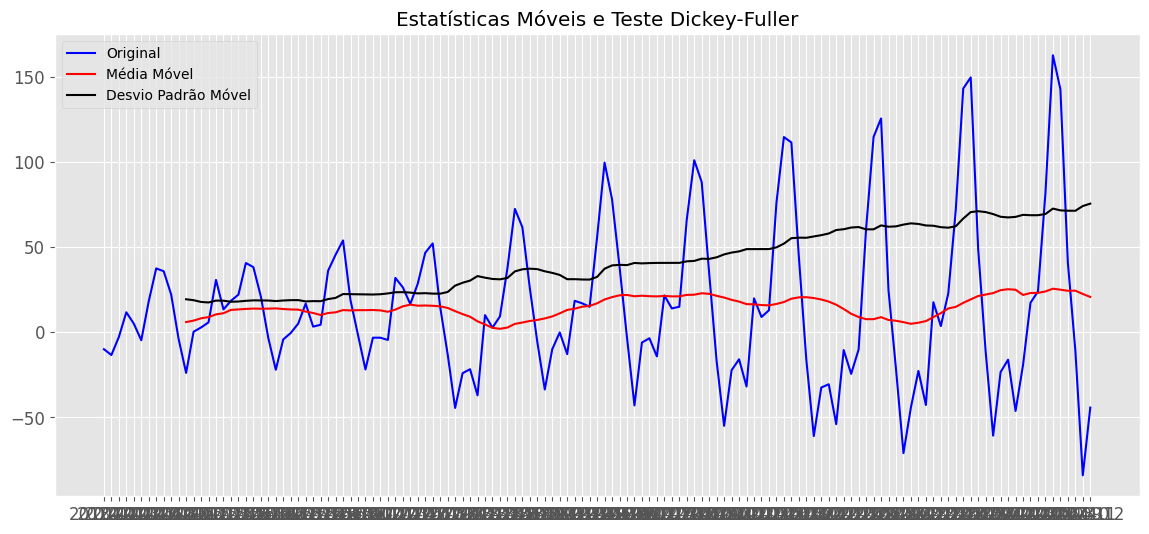


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -3.155457
Valor-p                           0.022712
Número de Lags Consideradas      13.000000
Número de Observações Usadas    119.000000
Valor Crítico (1%)               -3.486535
Valor Crítico (5%)               -2.886151
Valor Crítico (10%)              -2.579896
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [101]:
# Executando o teste de estacionaridade
dsa_testa_estacionaridade(diff_original_suavizada)

In [106]:
df_serie = pd.read_csv("./dataset.csv", header= None, names = schema) 

In [107]:
df_serie.set_index('mes', inplace=True)

In [108]:
# Aplicando suavização exponencial
# Observe que estamos aplicando a suavização à série original (antes de aplicar a suavização anterior)
serie_suavizada_exp = df_serie.ewm(alpha = 0.2, adjust = True).mean()

In [110]:
serie_suavizada_exp

usuarios_ativos
mes                     
2013-01       110.000000
2013-02       116.111111
2013-03       123.852459
2013-04       124.918699
2013-05       125.835317
...                  ...
2024-08       512.214093
2024-09       511.371274
2024-10       501.297019
2024-11       479.037615
2024-12       469.630092

[144 rows x 1 columns]

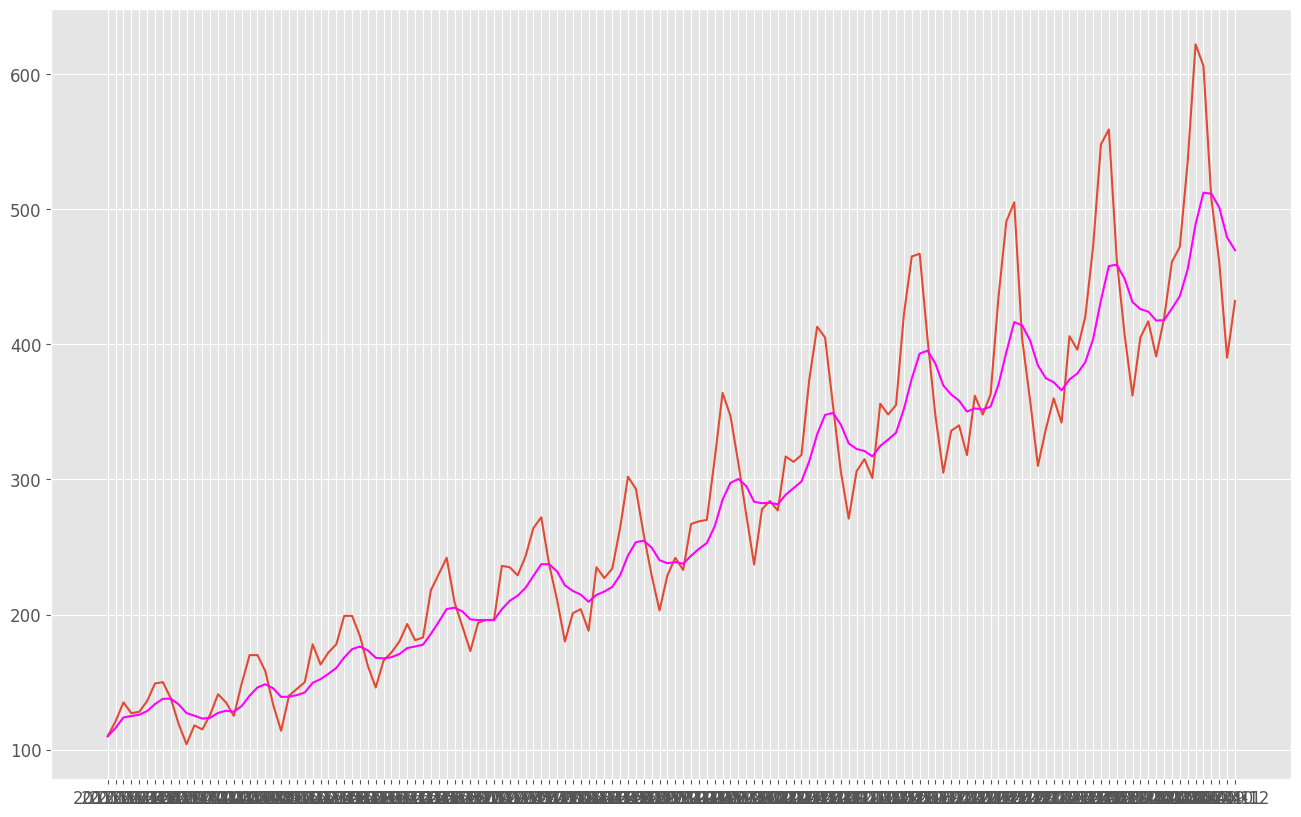

In [111]:
# Plt das séries
plt.plot(df_serie)
plt.plot(serie_suavizada_exp, color = 'magenta')
plt.show();

In [112]:
diff_original_suav_exp = df_serie.usuarios_ativos - serie_suavizada_exp.usuarios_ativos

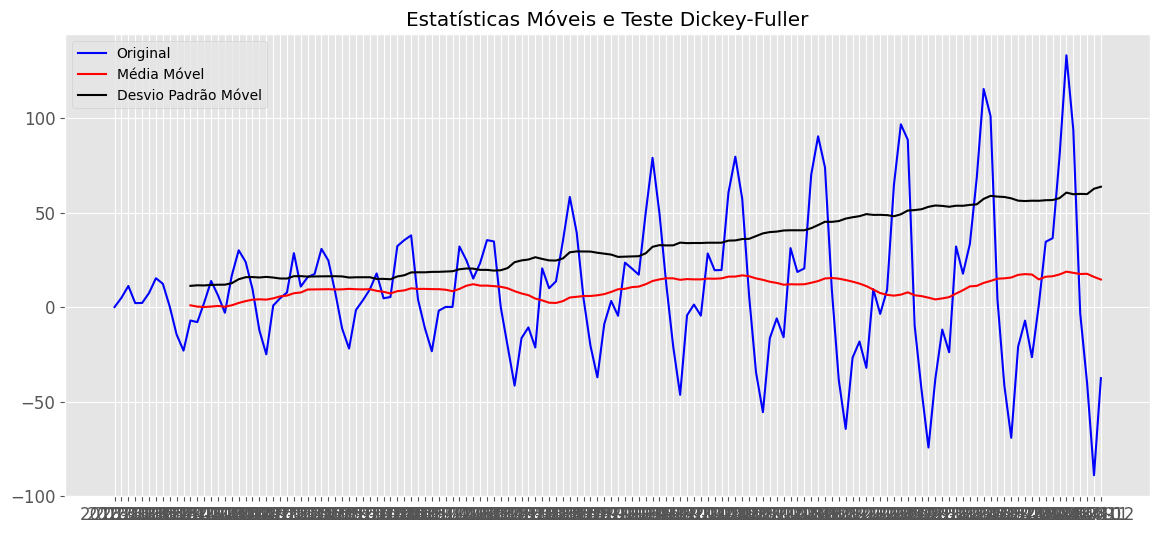


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -2.835903
Valor-p                           0.053325
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [113]:
# Executando o teste de estacionaridade
dsa_testa_estacionaridade(diff_original_suav_exp)

In [115]:
dados = pd.read_csv("./dataset.csv", header= None, names = schema, index_col = 0)

In [116]:
dados.head(10)

usuarios_ativos
mes                     
2013-01              110
2013-02              121
2013-03              135
2013-04              127
2013-05              128
2013-06              136
2013-07              149
2013-08              150
2013-09              138
2013-10              119

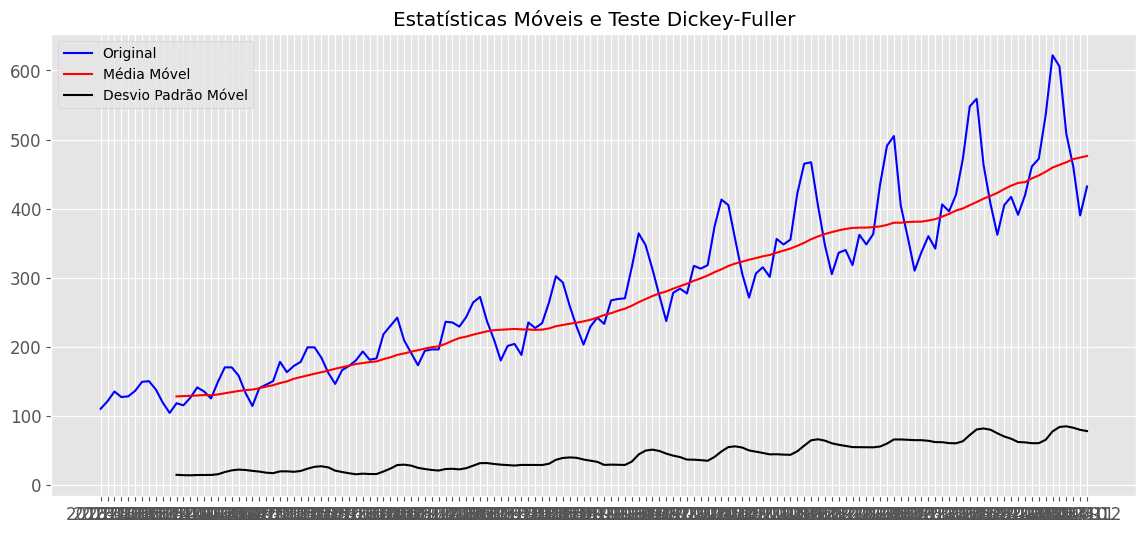


Resultado do Teste Dickey-Fuller:
Estatística do Teste              0.809204
Valor-p                           0.991783
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [117]:
dsa_testa_estacionaridade(dados)

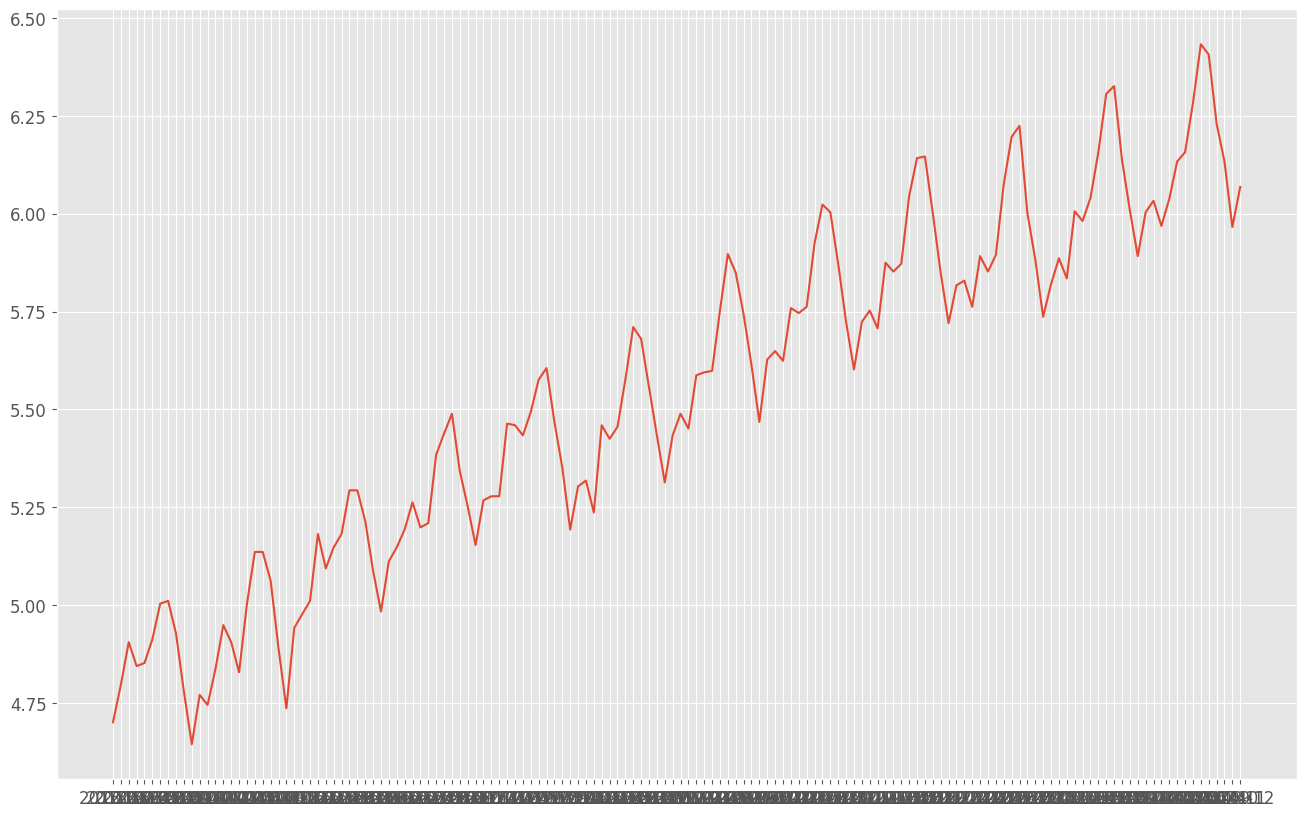

In [118]:
# Transformação de log
dados_serie_log = np.log(dados)
plt.plot(dados_serie_log)

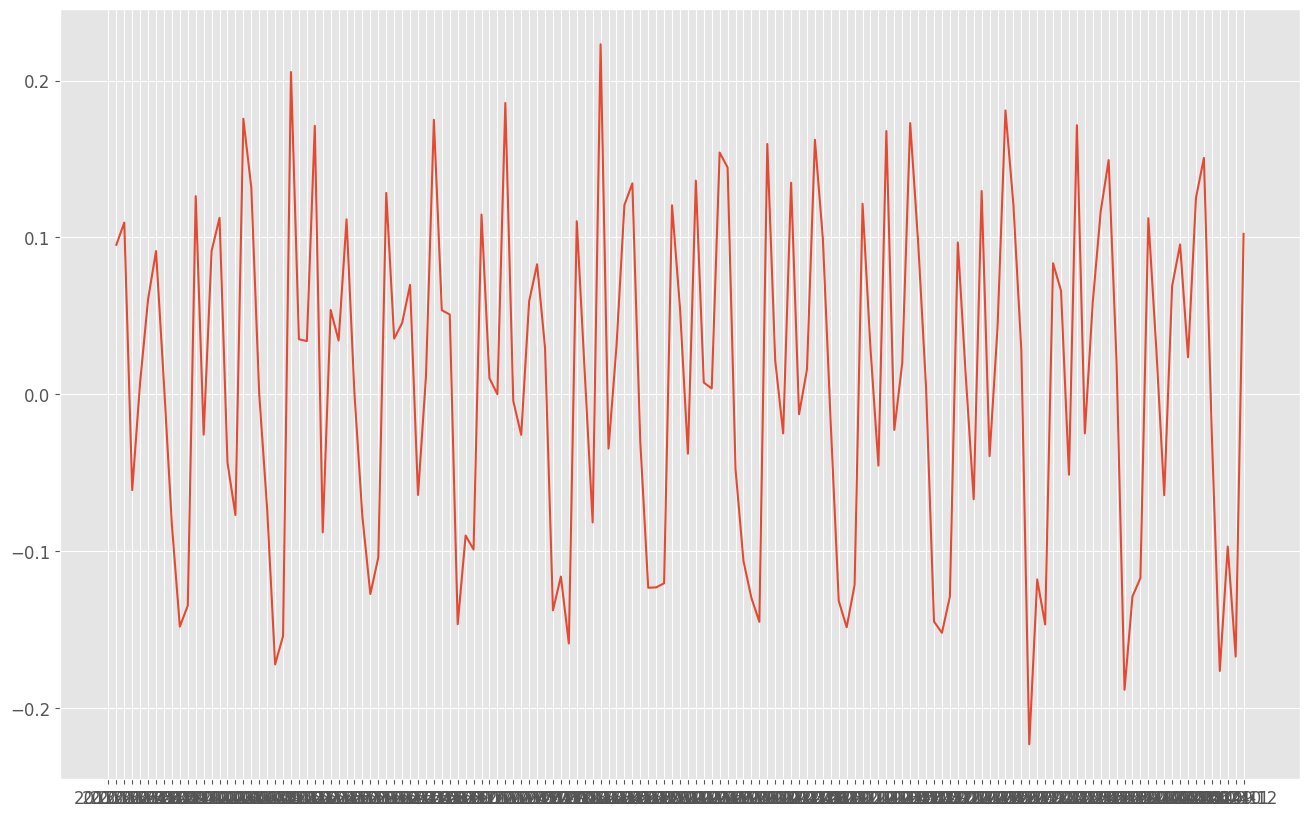

In [119]:
# Diferenciação Para Remover Tendência - Exemplo 1
# O método shift() move os dados em uma unidade
# Observe que estamos usando a série com transformação de log já aplicada
dados_serie_diff1 = dados_serie_log.usuarios_ativos - dados_serie_log.usuarios_ativos.shift()
plt.plot(dados_serie_diff1)
plt.show();

/var/folders/5z/nms2vp9s0_1dm1130xnk264w0000gn/T/ipykernel_69560/3931780994.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = dataset[i] - dataset[i - interval]


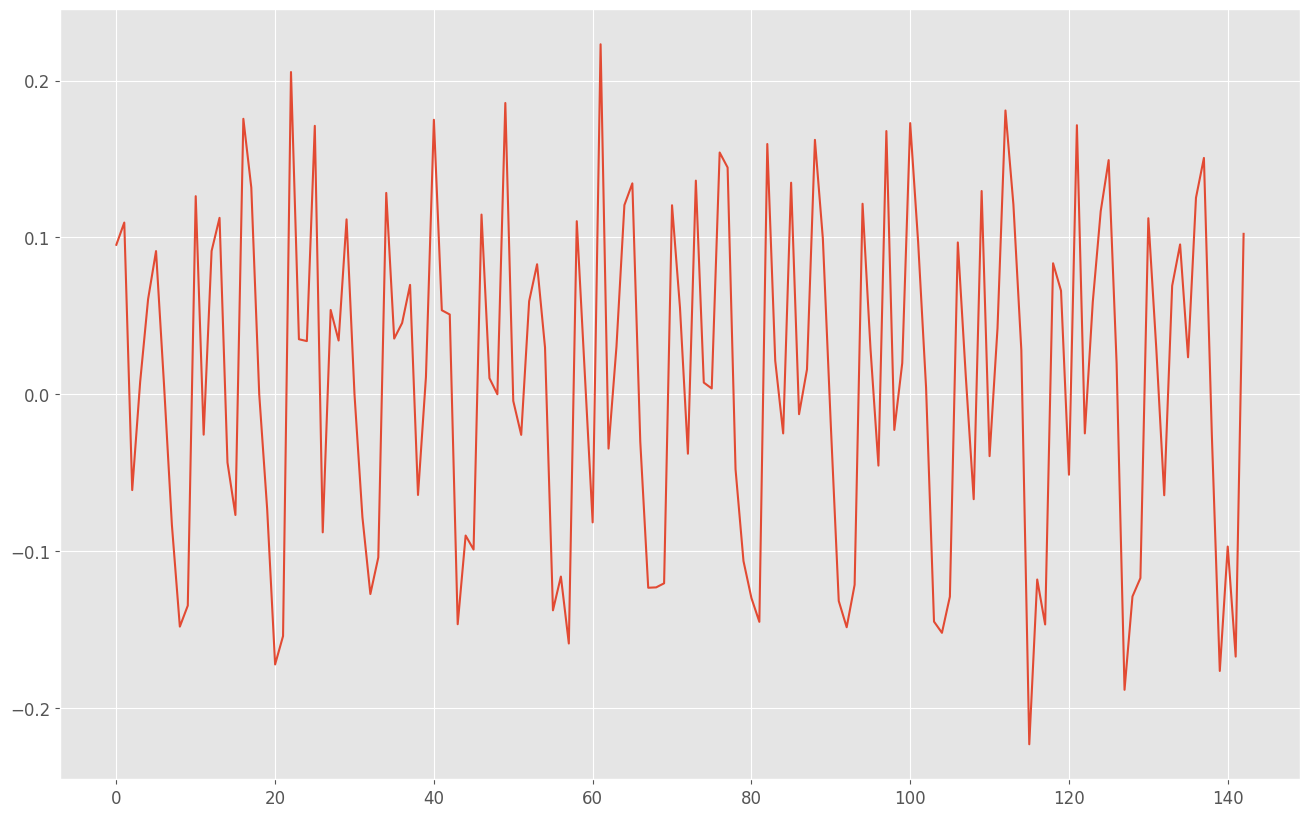

In [120]:
# Você pode criar sua função para diferenciação, se desejar:
def dsa_diffFunc(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff
  
# Diferenciação Para Remover Tendência - Exemplo 2
# Observe que estamos usando a série com transformação de log
dados_serie_diff2 = dsa_diffFunc(dados_serie_log['usuarios_ativos'])
plt.plot(dados_serie_diff2)

In [121]:
# Converte em dataframe, a lista gerada ao aplicar a diferenciação
dados_serie_diff2_df = pd.DataFrame(dados_serie_diff2) 

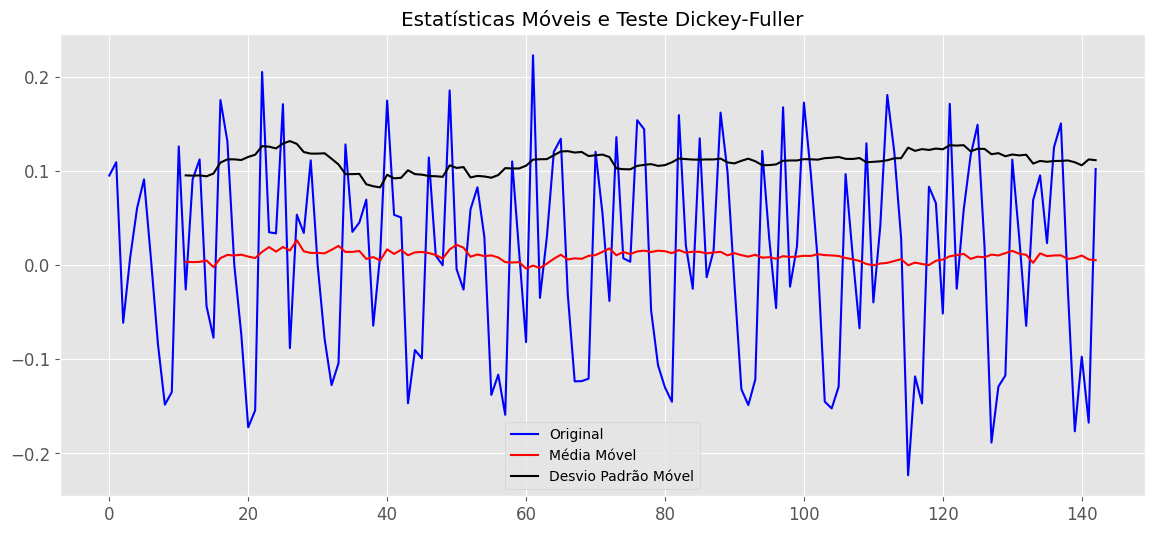


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -3.090791
Valor-p                           0.027242
Número de Lags Consideradas      12.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [122]:
# Vamos testar a estacionaridade da série após a diferenciação para remover a tendência
# Como os 2 exemplos anteriores geram o mesmo resultado, vamos usar o segundo
dsa_testa_estacionaridade(dados_serie_diff2_df)

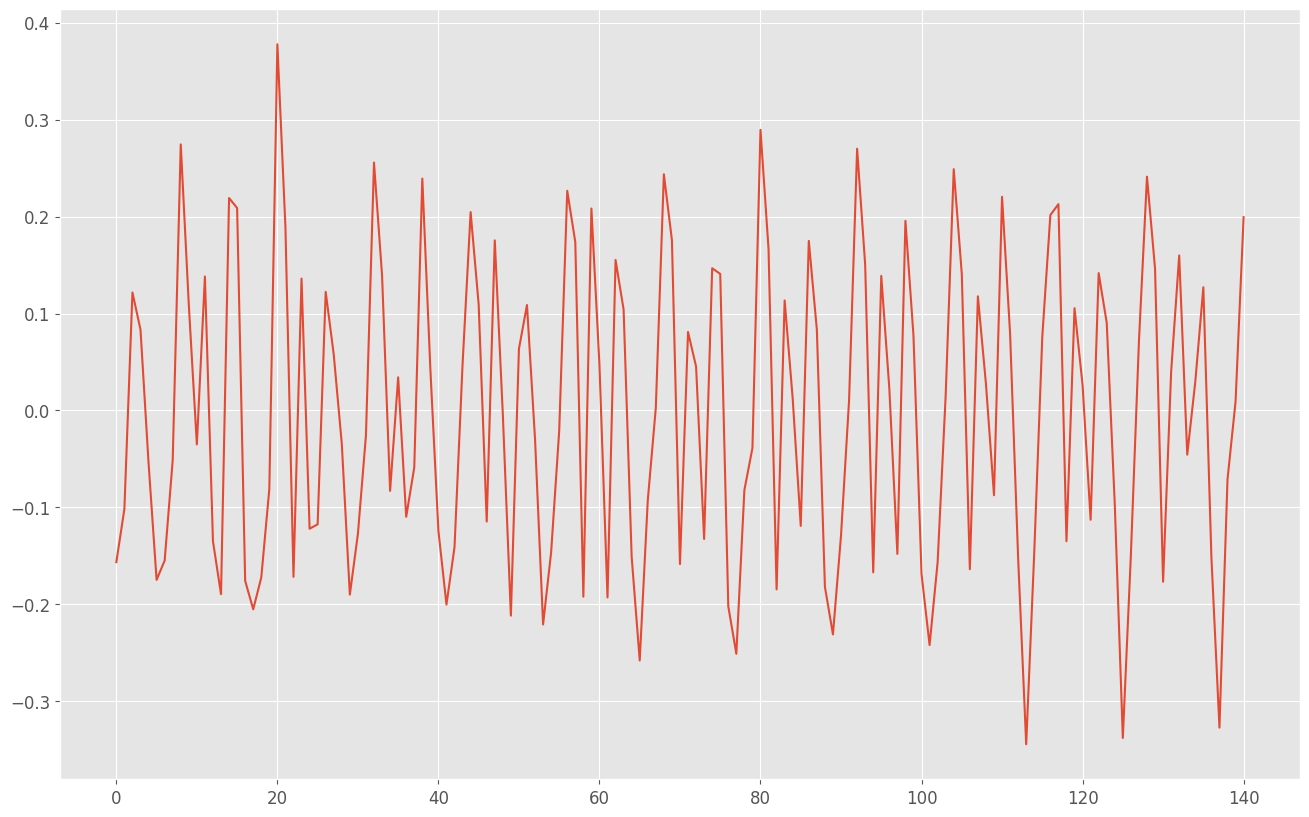

In [123]:
# Diferenciação para remover sazonalidade
# Observe o valor 2. Representa o intervalo para calcular a diferenciação. 
# Colocamos o valor 2 apenas para mostrar que é possível, mas se usarmos o valor 1 como usamos na 
# primeira diferenciação, o resultado é tão bom quanto.
dados_serie_diff3 = dsa_diffFunc(dados_serie_diff2, 2)
plt.plot(dados_serie_diff3)
plt.show();

In [124]:
# Converte em dataframe a lista gerada ao aplicar a diferenciação
dados_serie_final = pd.DataFrame(dados_serie_diff3) 

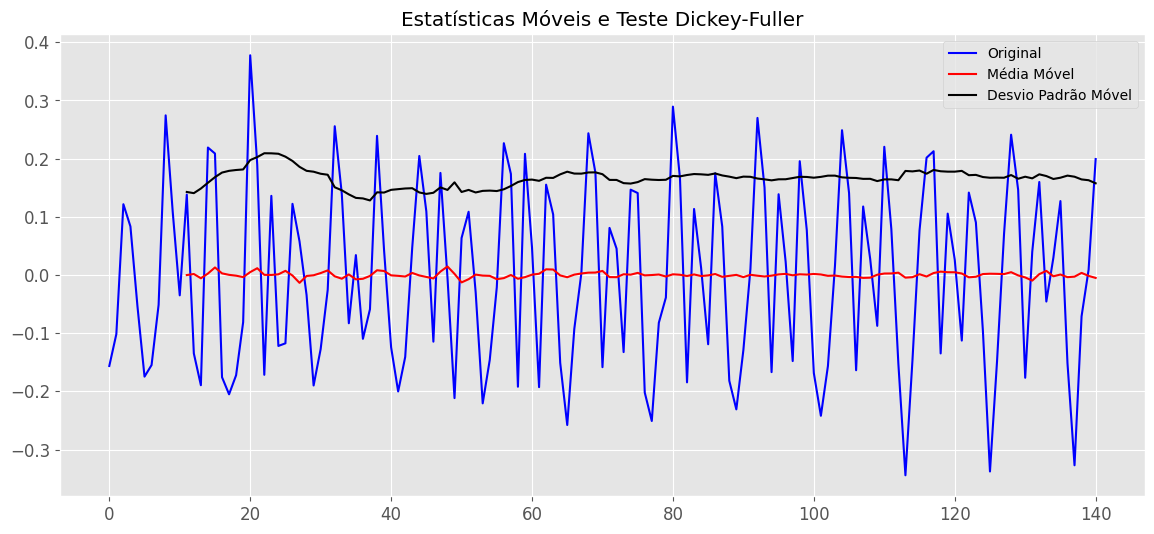


Resultado do Teste Dickey-Fuller:
Estatística do Teste           -1.506252e+01
Valor-p                         8.961787e-28
Número de Lags Consideradas     1.000000e+01
Número de Observações Usadas    1.300000e+02
Valor Crítico (1%)             -3.481682e+00
Valor Crítico (5%)             -2.884042e+00
Valor Crítico (10%)            -2.578770e+00
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [125]:
# Testa a estacionaridade
dsa_testa_estacionaridade(dados_serie_final)

In [127]:
# Carrega os dados
df_dsa = pd.read_csv("dataset_model.csv")
df_dsa_novos_dados = pd.read_csv("novos_dados.csv")

In [128]:
df_dsa.head(10)

id              data  usuarios_ativos
0   0  25-08-2021 00:00                8
1   1  25-08-2021 01:00                2
2   2  25-08-2021 02:00                6
3   3  25-08-2021 03:00                2
4   4  25-08-2021 04:00                2
5   5  25-08-2021 05:00                2
6   6  25-08-2021 06:00                2
7   7  25-08-2021 07:00                2
8   8  25-08-2021 08:00                6
9   9  25-08-2021 09:00                2

In [130]:
df_dsa.shape

(18288, 3)

In [132]:
# Converte a coluna de data para o tipo correto
df_dsa['data'] = pd.to_datetime(df_dsa.data, format = '%d-%m-%Y %H:%M')
# Converte a coluna de data para o tipo correto
df_dsa_novos_dados['data'] = pd.to_datetime(df_dsa_novos_dados.data, format = '%d-%m-%Y %H:%M')

In [133]:
df_dsa.dtypes

id                          int64
data               datetime64[ns]
usuarios_ativos             int64
dtype: object

In [134]:
df_dsa_novos_dados.dtypes

id               int64
data    datetime64[ns]
dtype: object

In [135]:
# Definimos o índice do dataset
df_dsa.index = df_dsa['data']

In [136]:
# Removemos a coluna ID, pois ela não é relevante neste caso
df_dsa.drop('id', axis = 1, inplace = True)

In [137]:
# Removemos a coluna data, pois ela não é relevante neste caso
df_dsa.drop('data', axis = 1, inplace = True)

In [138]:
df_dsa.head(10)

usuarios_ativos
data                                
2021-08-25 00:00:00                8
2021-08-25 01:00:00                2
2021-08-25 02:00:00                6
2021-08-25 03:00:00                2
2021-08-25 04:00:00                2
2021-08-25 05:00:00                2
2021-08-25 06:00:00                2
2021-08-25 07:00:00                2
2021-08-25 08:00:00                6
2021-08-25 09:00:00                2

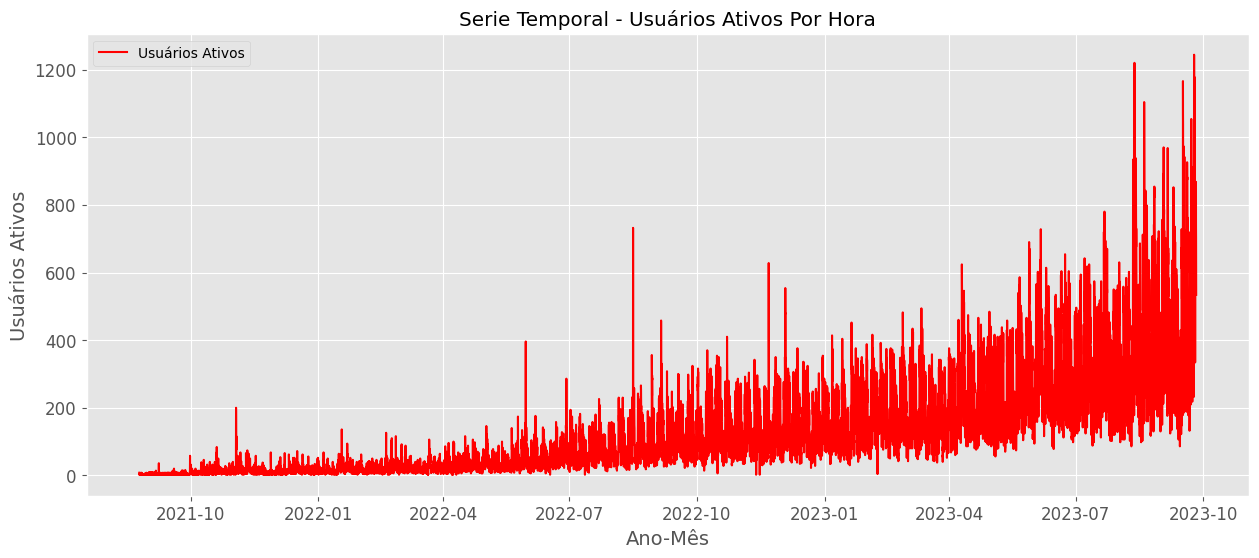

In [142]:
# Variável target 
target = df_dsa['usuarios_ativos']

# Plot
figure(figsize = (15, 6))
plt.title("Serie Temporal - Usuários Ativos Por Hora")
plt.plot(target, label = "Usuários Ativos", color = 'red')
plt.xlabel("Ano-Mês")
plt.ylabel("Usuários Ativos")
plt.legend(loc = "best")
plt.show();

In [143]:
# Os dados de treino serão divididos em dados de treino e validação
df_treino = df_dsa.iloc[0:16057]
df_valid = df_dsa.iloc[16058:]

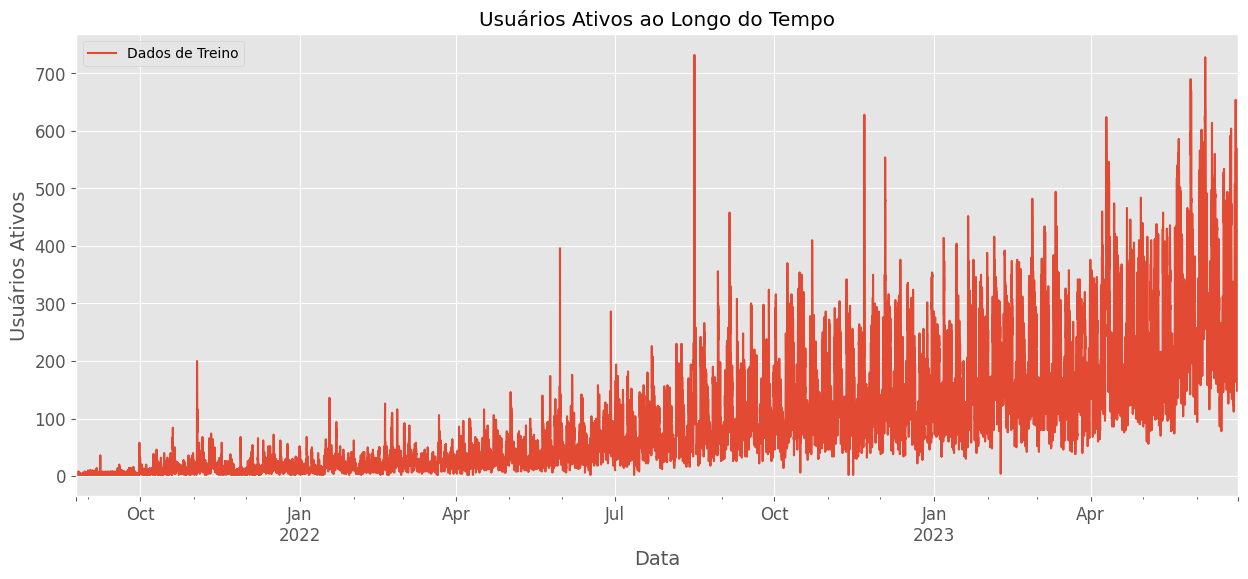

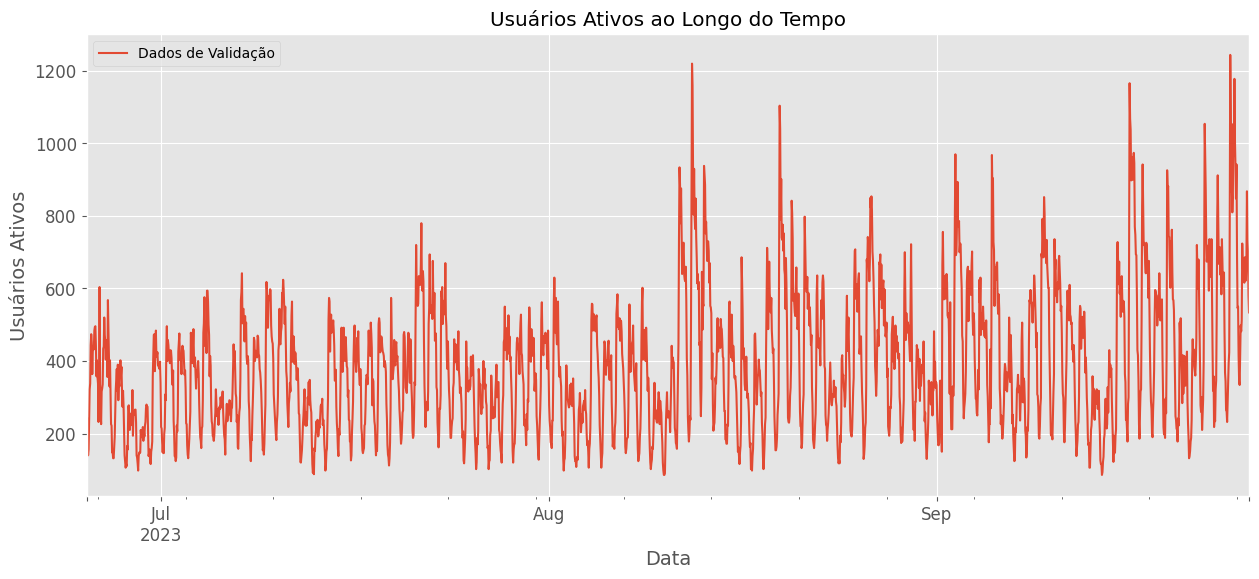

In [145]:
# Plot
figure(figsize = (15, 6))
df_treino.usuarios_ativos.plot(title = 'Usuários Ativos ao Longo do Tempo', 
                               fontsize = 12, 
                               label = 'Dados de Treino') 
plt.xlabel("Data") 
plt.ylabel("Usuários Ativos") 
plt.legend(loc = 'best') 
plt.show()

# Plot
figure(figsize = (15, 6))
df_valid.usuarios_ativos.plot(title = 'Usuários Ativos ao Longo do Tempo', 
                              fontsize = 12, 
                              label = 'Dados de Validação') 
plt.xlabel("Data") 
plt.ylabel("Usuários Ativos") 
plt.legend(loc = 'best') 
plt.show()

<Figure size 1500x600 with 0 Axes>

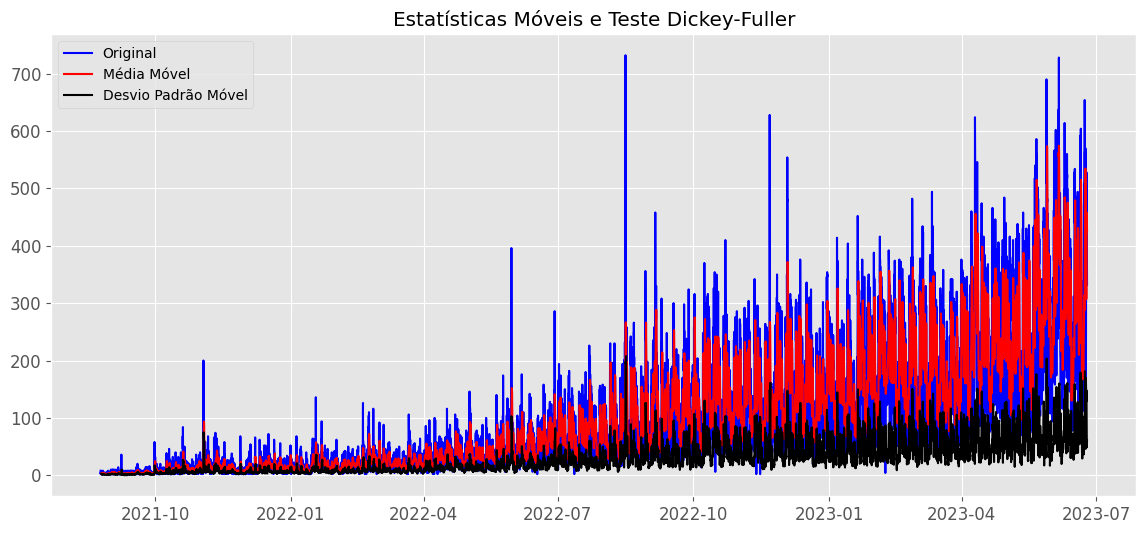


Resultado do Teste Dickey-Fuller:
Estatística do Teste               -5.038033
Valor-p                             0.000019
Número de Lags Consideradas        43.000000
Número de Observações Usadas    16013.000000
Valor Crítico (1%)                 -3.430758
Valor Crítico (5%)                 -2.861721
Valor Crítico (10%)                -2.566866
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [146]:
# Vamos testar a estacionaridade da série antes de qualquer transformação
figure(figsize = (15, 6))
dsa_testa_estacionaridade(df_treino)

In [147]:
# Criamos um array com os valores da variável target em treino
array_usuarios_ativos_treino = np.asarray(df_treino.usuarios_ativos)

In [148]:
array_usuarios_ativos_treino.dtype

dtype('int64')

In [149]:
type(array_usuarios_ativos_treino)

numpy.ndarray

In [150]:
# Cria uma cópia dos dados de validação para usar na comparação dos dados reais com as previsões
df_valid_cp = df_valid.copy()

In [151]:
# Previsão. Sim, isso é o Método Naive!
df_valid_cp['previsao_naive'] = array_usuarios_ativos_treino[len(array_usuarios_ativos_treino) - 1] 
# Colocamos lado a lado, valor real e valor "previsto"
df_valid_cp[['usuarios_ativos', 'previsao_naive']].head()

usuarios_ativos  previsao_naive
data                                                
2023-06-25 02:00:00              218             332
2023-06-25 03:00:00              244             332
2023-06-25 04:00:00              168             332
2023-06-25 05:00:00              140             332
2023-06-25 06:00:00              156             332

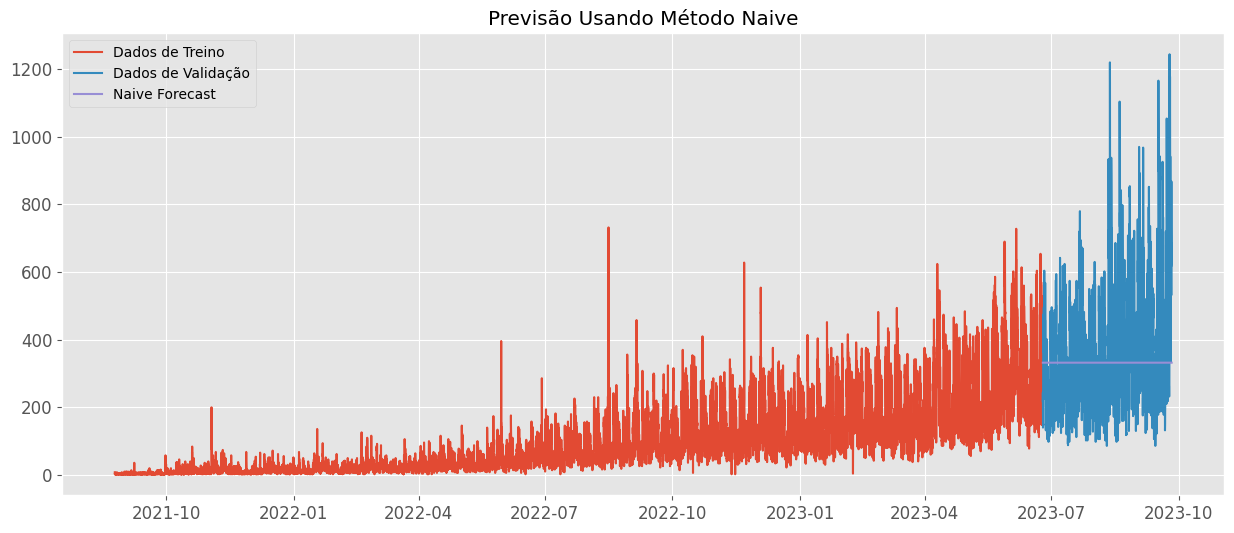

In [152]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Método Naive") 
plt.plot(df_treino.index, df_treino['usuarios_ativos'], label = 'Dados de Treino') 
plt.plot(df_valid.index, df_valid['usuarios_ativos'], label = 'Dados de Validação') 
plt.plot(df_valid_cp.index, df_valid_cp['previsao_naive'], label = 'Naive Forecast') 
plt.legend(loc = 'best') 
plt.show()

In [153]:
# Define valor real e valor previsto
y_true = df_valid_cp.usuarios_ativos
y_pred = df_valid_cp.previsao_naive

# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

195.06210118417584


In [156]:
# Os dados devem estar no formato NumPy para o treino do modelo
array_dados_treino = np.asarray(df_treino['usuarios_ativos'])

# Versão 1 do modelo - Simple Exponential Smoothing
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html

# A função SimpleExpSmoothing() recebe os dados de treino no formato de array numpy
# A função fit() faz o treinamento

# O hiperparâmetro smoothing_level define o nível de suavização exponencial na série
# O hiperparâmetro optimized define se teremos ou não otimização 

# Versão 1 do modelo - Simple Exponential Smoothing 
modelo_v1 = SimpleExpSmoothing(array_dados_treino).fit(smoothing_level = 0.2, optimized = True)

/Users/brunoramoslemos/.local/share/virtualenvs/data_science_repo-dhSa4S5y/lib/python3.13/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


In [157]:
# Previsões com o Modelo
df_valid['previsoes_v1'] = modelo_v1.forecast(len(df_valid)) 

/var/folders/5z/nms2vp9s0_1dm1130xnk264w0000gn/T/ipykernel_69560/2315390024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['previsoes_v1'] = modelo_v1.forecast(len(df_valid))


In [158]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid[['usuarios_ativos', 'previsoes_v1']].head()

usuarios_ativos  previsoes_v1
data                                              
2023-06-25 02:00:00              218    395.388938
2023-06-25 03:00:00              244    395.388938
2023-06-25 04:00:00              168    395.388938
2023-06-25 05:00:00              140    395.388938
2023-06-25 06:00:00              156    395.388938

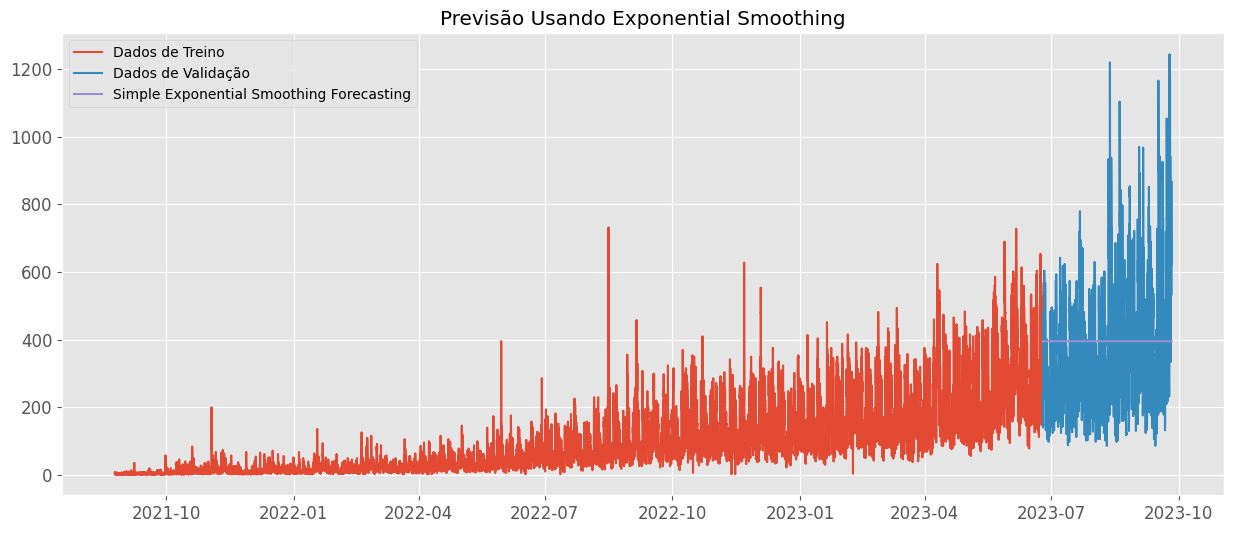

In [159]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(df_treino['usuarios_ativos'], label = 'Dados de Treino')
plt.plot(df_valid['usuarios_ativos'], label = 'Dados de Validação')
plt.plot(df_valid['previsoes_v1'], label = 'Simple Exponential Smoothing Forecasting') 
plt.legend(loc = 'best') 
plt.show()

In [160]:
# Define valor real e valor previsto
y_true = df_valid.usuarios_ativos
y_pred = df_valid.previsoes_v1

# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

186.52867297329848


In [203]:
# Versão 2 do modelo - Double Exponential Smoothing 
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

# Observe que estamos usando a função ExponentialSmoothing().
# Ao usar o hiperparâmetro trend, definimos o método Double Exponential Smoothing.
# Ao usar o hiperparâmetro seasonal, definimos o método Triple Exponential Smoothing.

# Vamos usar o Double. Como não temos sazonalidade na série, não faz muito sentido usar o Triple.
# Escolhi a série aditiva
modelo_v2 = ExponentialSmoothing(np.asarray(df_treino['usuarios_ativos']), 
                                 seasonal='add', seasonal_periods=6).fit(smoothing_level = 0.9, 
                                                         optimized = True) 

In [204]:
# Previsões com o Modelo
df_valid.loc[:,'previsoes_v2'] = modelo_v2.forecast(len(df_valid))

In [205]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid[['usuarios_ativos', 'previsoes_v1', 'previsoes_v2']].head()

usuarios_ativos  previsoes_v1  previsoes_v2
data                                                            
2023-06-25 02:00:00              218    395.388938    324.791343
2023-06-25 03:00:00              244    395.388938    337.779949
2023-06-25 04:00:00              168    395.388938    335.381977
2023-06-25 05:00:00              140    395.388938    353.722079
2023-06-25 06:00:00              156    395.388938    341.047040

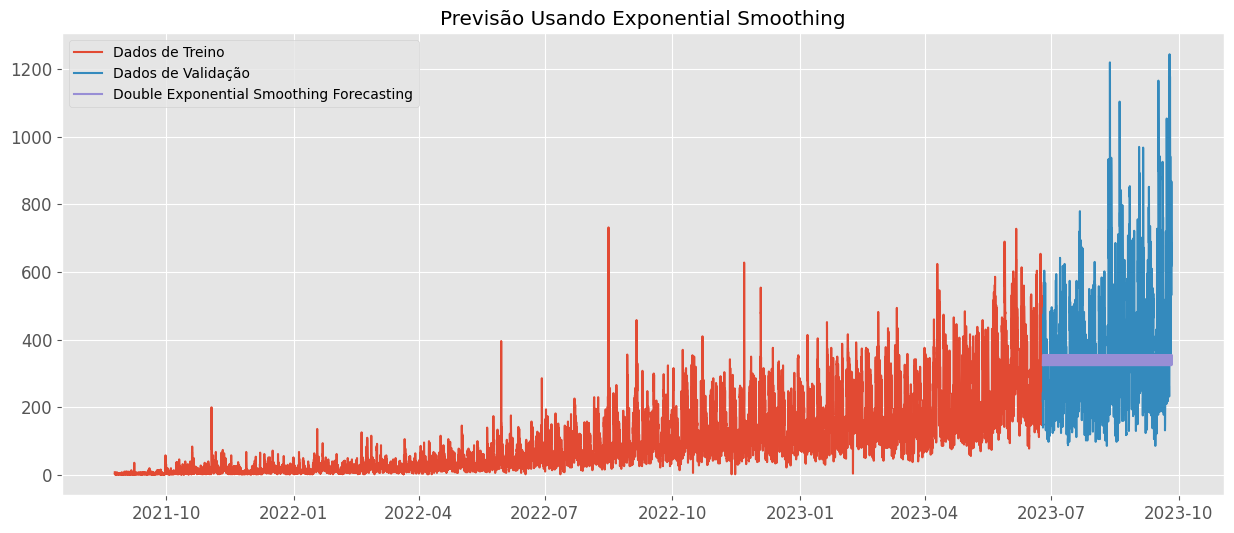

In [206]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(df_treino['usuarios_ativos'], label = 'Dados de Treino')
plt.plot(df_valid['usuarios_ativos'], label = 'Dados de Validação')
plt.plot(df_valid['previsoes_v2'], label = 'Double Exponential Smoothing Forecasting') 
plt.legend(loc = 'best') 
plt.show()

In [207]:
# Define valor real e valor previsto
y_true = df_valid.usuarios_ativos
y_pred = df_valid.previsoes_v2

# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

192.952080068707


In [210]:
# Aplicando transformação de log (colocando os dados na mesma escala, o que é requerido pelos modelos ARIMA)
df_treino_log = np.log(df_treino['usuarios_ativos']) 
# Cria o Modelo ARIMA

# Definimos:

# p = 2
# d = 1
# q = 0

# Modelo
modelo_AR = ARIMA(df_treino_log, order = (2, 1, 0), freq = 'H')

/Users/brunoramoslemos/.local/share/virtualenvs/data_science_repo-dhSa4S5y/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:595: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = to_offset(freq)
/Users/brunoramoslemos/.local/share/virtualenvs/data_science_repo-dhSa4S5y/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [211]:
# Treinamento
modelo_v3 = modelo_AR.fit()  

In [212]:
# Dados Reais e Previsões (em treino)
dados_reais = df_treino_log
previsoes_v3 = modelo_v3.fittedvalues

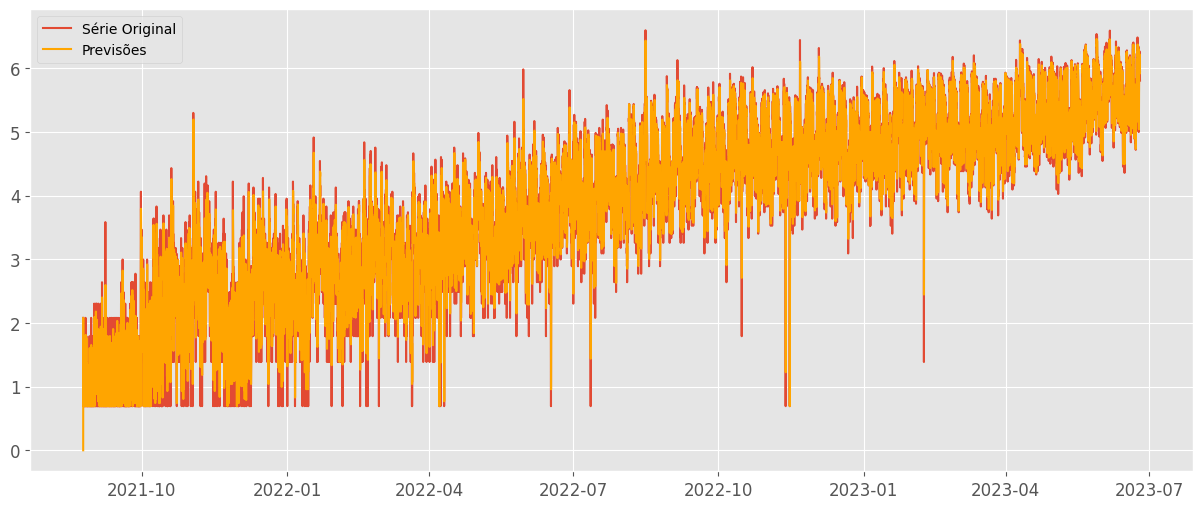

In [213]:
# Plot
figure(figsize = (15, 6))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes_v3, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [214]:
# Sumário do Modelo 
modelo_v3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        usuarios_ativos   No. Observations:                16057
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -8119.356
Date:                Mon, 12 May 2025   AIC                          16244.711
Time:                        20:57:37   BIC                          16267.763
Sample:                    08-25-2021   HQIC                         16252.334
                         - 06-25-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3419      0.005    -68.096      0.000      -0.352      -0.332
ar.L2         -0.0695      0.006    -11.737      0.000      -0.081      -0.058
sigma2         0.1610      0.001    158.760      0.000       0.159       0.163
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12378.93
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [215]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
df_valid_log = np.log(df_valid['usuarios_ativos'])

In [216]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
df_previsoes_v3 = modelo_v3.forecast(len(df_valid_log), alpha = 0.05) 

/Users/brunoramoslemos/.local/share/virtualenvs/data_science_repo-dhSa4S5y/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [217]:
# Criamos a série para o gráfico
fc_series = pd.Series(df_previsoes_v3, index = df_valid_log.index)

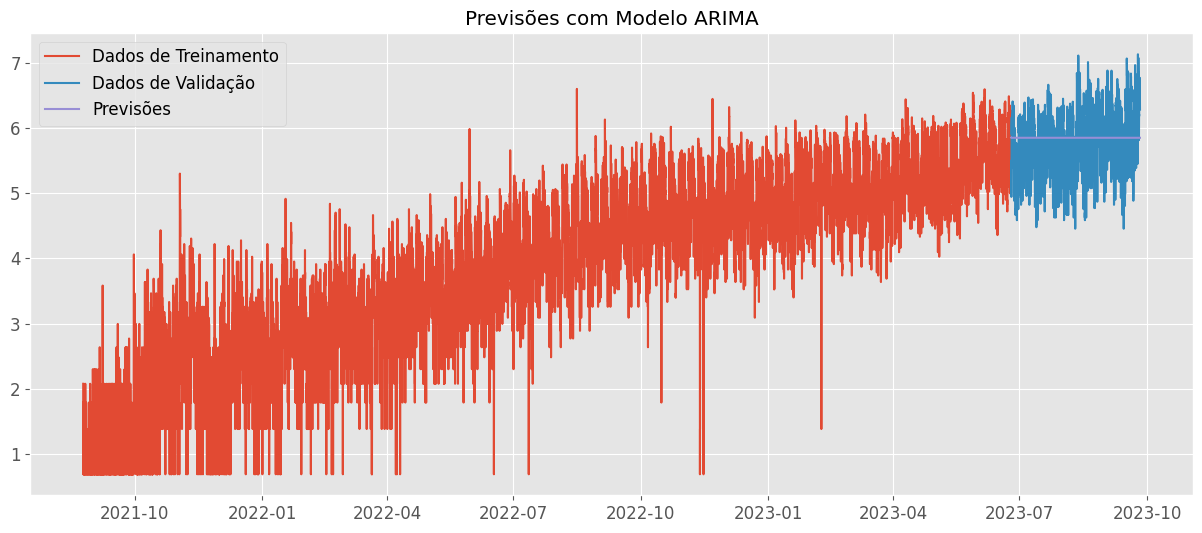

In [218]:
# Plot
figure(figsize = (15, 6))
plt.plot(df_treino_log, label = 'Dados de Treinamento')
plt.plot(df_valid_log, label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [219]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [220]:
# Define valor real e valor previsto
y_true = df_valid_log
y_pred = fc_series
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.5136328974922727


In [221]:
# Cria o modelo
modelo_SARIMAX = SARIMAX(df_treino_log, trend = 'n', order = (6,1,0), seasonal_order = (0,1,1,12))

/Users/brunoramoslemos/.local/share/virtualenvs/data_science_repo-dhSa4S5y/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/brunoramoslemos/.local/share/virtualenvs/data_science_repo-dhSa4S5y/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [222]:
# Treinamento do modelo
modelo_v4 = modelo_SARIMAX.fit(disp = True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11522D-01    |proj g|=  8.36031D-01


 This problem is unconstrained.



At iterate    1    f=  5.24014D-01    |proj g|=  2.60584D-01

At iterate    2    f=  5.20111D-01    |proj g|=  7.32641D-02

At iterate    3    f=  5.18655D-01    |proj g|=  7.31878D-02

At iterate    4    f=  5.10825D-01    |proj g|=  2.06995D-01

At iterate    5    f=  5.07025D-01    |proj g|=  1.18640D-01

At iterate    6    f=  4.99814D-01    |proj g|=  9.16692D-02

At iterate    7    f=  4.94614D-01    |proj g|=  1.75204D-01

At iterate    8    f=  4.84403D-01    |proj g|=  2.11905D-01

At iterate    9    f=  4.71473D-01    |proj g|=  5.02832D-02

At iterate   10    f=  4.68591D-01    |proj g|=  7.76649D-02

At iterate   11    f=  4.64945D-01    |proj g|=  4.54093D-02

At iterate   12    f=  4.62470D-01    |proj g|=  1.13749D-02

At iterate   13    f=  4.61038D-01    |proj g|=  2.21285D-02

At iterate   14    f=  4.60431D-01    |proj g|=  7.24852D-02

At iterate   15    f=  4.60004D-01    |proj g|=  2.04912D-02

At iterate   16    f=  4.59813D-01    |proj g|=  9.48335D-03

At iter

In [223]:
# Dados Reais e Previsões (em treino)
dados_reais = df_treino_log
previsoes_v4 = modelo_v4.fittedvalues

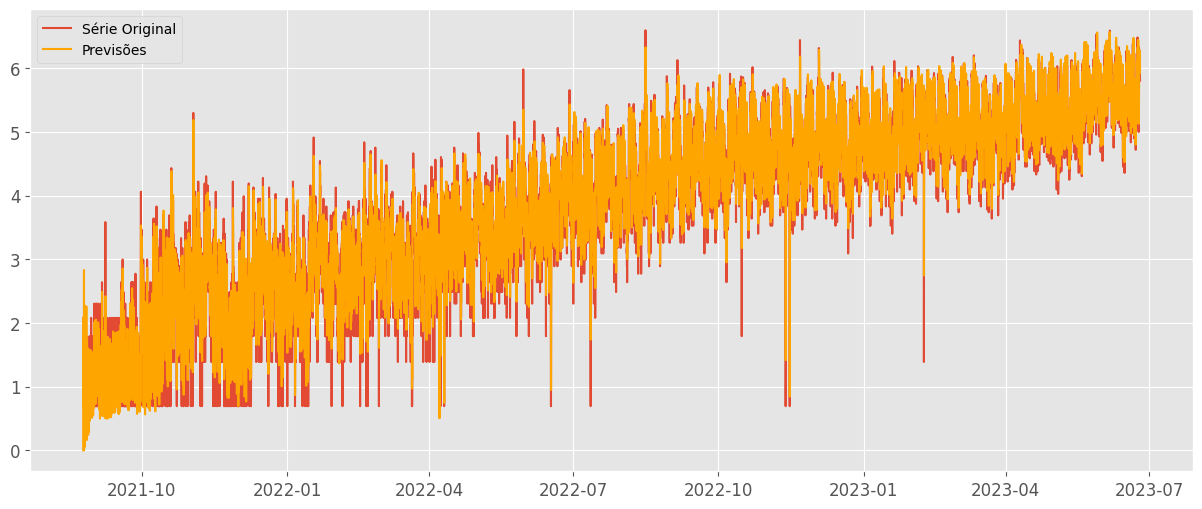

In [224]:
# Plot
figure(figsize = (15, 6))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes_v4, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [225]:
# Sumário do Modelo 
modelo_v4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      usuarios_ativos   No. Observations:                16057
Model:             SARIMAX(6, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -7380.094
Date:                              Mon, 12 May 2025   AIC                          14776.188
Time:                                      21:13:56   BIC                          14837.652
Sample:                                  08-25-2021   HQIC                         14796.514
                                       - 06-25-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4178      0.005    -85.103      0.000      -0.427      -0.408
ar.L2         -0.1444      0.006    -22.494      0.000      -0.157      -0.132
ar.L3         -0.0446      0.007     -6.651      0.000      -0.058      -0.031
ar.L4         -0.0097      0.006     -1.584      0.113      -0.022       0.002
ar.L5          0.0146      0.006      2.399      0.016       0.003       0.027
ar.L6         -0.0011      0.006     -0.178      0.859      -0.013       0.011
ma.S.L12      -0.9965      0.001   -985.547      0.000      -0.998      -0.995
sigma2         0.1464      0.001    158.159      0.000       0.145       0.148
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15818.04
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [226]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
df_previsoes_v4 = modelo_v4.forecast(len(df_valid_log), alpha = 0.05) 

/Users/brunoramoslemos/.local/share/virtualenvs/data_science_repo-dhSa4S5y/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


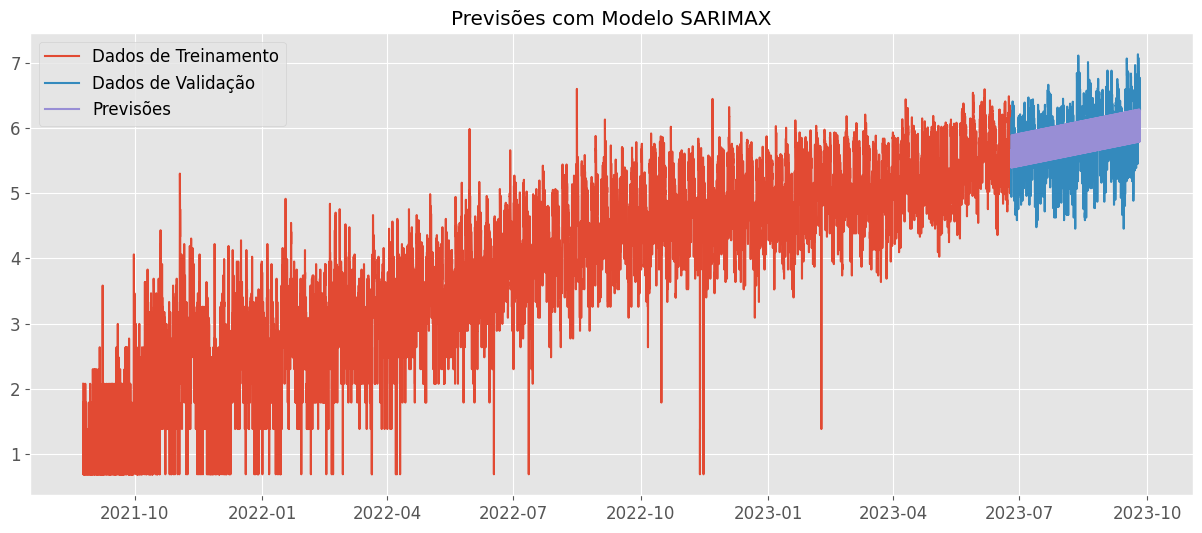

In [227]:
# Cria a série para o gráfico
fc_series = pd.Series(df_previsoes_v4, index = df_valid_log.index)

# Plot
figure(figsize = (15, 6))
plt.plot(df_treino_log, label = 'Dados de Treinamento')
plt.plot(df_valid_log, label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.title('Previsões com Modelo SARIMAX')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [228]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True) 

In [229]:
# Define valor real e valor previsto
y_true = df_valid_log
y_pred = fc_series

In [230]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.4634340042818391


In [248]:
# Vamos fazer a previsão para uma janela de 30 horas
previsoes = modelo_v4.predict(start = df_dsa_novos_dados.data[0], 
                              end = df_dsa_novos_dados.data[1000], 
                              dynamic = False)

In [249]:
previsoes[1:30]

2023-09-26 01:00:00    6.106457
2023-09-26 02:00:00    6.053935
2023-09-26 03:00:00    5.958873
2023-09-26 04:00:00    5.854595
2023-09-26 05:00:00    5.790944
2023-09-26 06:00:00    5.837258
2023-09-26 07:00:00    5.936081
2023-09-26 08:00:00    6.011456
2023-09-26 09:00:00    6.109187
2023-09-26 10:00:00    6.256616
2023-09-26 11:00:00    6.284681
2023-09-26 12:00:00    6.256277
2023-09-26 13:00:00    6.108609
2023-09-26 14:00:00    6.056087
2023-09-26 15:00:00    5.961025
2023-09-26 16:00:00    5.856747
2023-09-26 17:00:00    5.793096
2023-09-26 18:00:00    5.839410
2023-09-26 19:00:00    5.938233
2023-09-26 20:00:00    6.013608
2023-09-26 21:00:00    6.111338
2023-09-26 22:00:00    6.258768
2023-09-26 23:00:00    6.286833
2023-09-27 00:00:00    6.258429
2023-09-27 01:00:00    6.110761
2023-09-27 02:00:00    6.058239
2023-09-27 03:00:00    5.963177
2023-09-27 04:00:00    5.858899
2023-09-27 05:00:00    5.795248
Freq: h, Name: predicted_mean, dtype: float64

In [243]:
# Inversa da transformação de log
np.exp(previsoes[1:30])

2023-09-26 01:00:00    448.746122
2023-09-26 02:00:00    425.785244
2023-09-26 03:00:00    387.173628
2023-09-26 04:00:00    348.833586
2023-09-26 05:00:00    327.322029
2023-09-26 06:00:00    342.838099
2023-09-26 07:00:00    378.448940
2023-09-26 08:00:00    408.077217
2023-09-26 09:00:00    449.972551
2023-09-26 10:00:00    521.451227
2023-09-26 11:00:00    536.293050
2023-09-26 12:00:00    521.274813
2023-09-26 13:00:00    449.712803
2023-09-26 14:00:00    426.702463
2023-09-26 15:00:00    388.007671
2023-09-26 16:00:00    349.585038
2023-09-26 17:00:00    328.027141
2023-09-26 18:00:00    343.576635
2023-09-26 19:00:00    379.264189
2023-09-26 20:00:00    408.956290
2023-09-26 21:00:00    450.941875
2023-09-26 22:00:00    522.574529
2023-09-26 23:00:00    537.448324
2023-09-27 00:00:00    522.397734
2023-09-27 01:00:00    450.681567
2023-09-27 02:00:00    427.621658
2023-09-27 03:00:00    388.843511
2023-09-27 04:00:00    350.338108
2023-09-27 05:00:00    328.733771
Freq: h, Name:

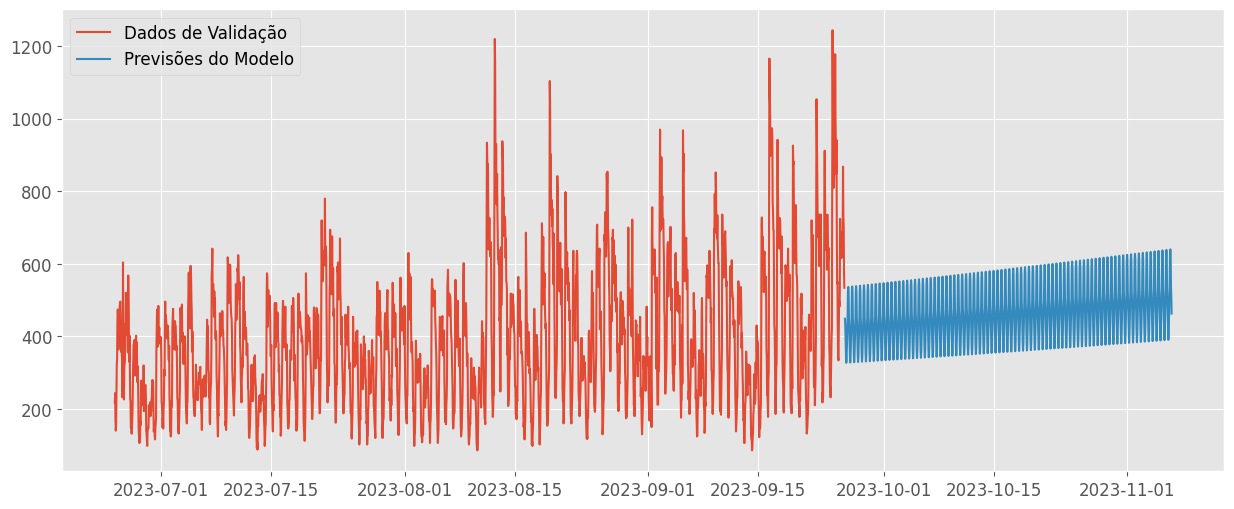

In [250]:
# Plot das Previsões
figure(figsize = (15, 6))
plt.plot(df_valid['usuarios_ativos'], label = 'Dados de Validação')
plt.plot(np.exp(previsoes[1:1000]), label = 'Previsões do Modelo')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [245]:
# Buscar as últimas 120 horas dos dados de validação
df_valid_ultimas_120_horas = df_valid['usuarios_ativos'].tail(120)

/var/folders/5z/nms2vp9s0_1dm1130xnk264w0000gn/T/ipykernel_69560/571276513.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  indice_previsoes = pd.date_range(start = inicio_previsoes, periods = len(previsoes[1:1000]), freq = 'H')


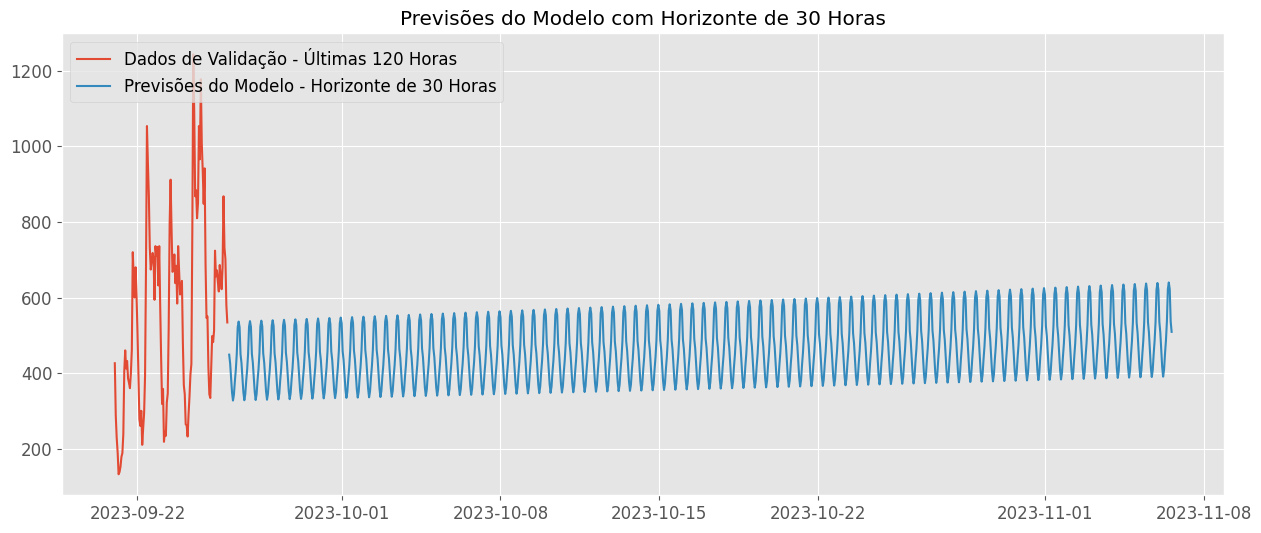

In [252]:
# Criamos uma nova série para as previsões com o índice correto
# O índice deve começar imediatamente após o último índice de df_valid_ultimas_120_horas
inicio_previsoes = df_valid_ultimas_120_horas.index[-1] + pd.Timedelta(hours = 1)
indice_previsoes = pd.date_range(start = inicio_previsoes, periods = len(previsoes[1:1000]), freq = 'H')
previsoes_series = pd.Series(np.exp(previsoes[1:1000]), index = indice_previsoes)

# Plot das Previsões
figure(figsize = (15, 6))
plt.plot(df_valid_ultimas_120_horas, label = 'Dados de Validação - Últimas 120 Horas')
plt.plot(previsoes_series, label='Previsões do Modelo - Horizonte de 30 Horas')
plt.title('Previsões do Modelo com Horizonte de 30 Horas')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show();